In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report

def load_features_and_labels(features_path, labels_path, segment_info_path):
    """
    Load features and labels from specified paths.
    """
    X = np.load(features_path)
    y = np.load(labels_path)
    segment_info = pd.read_csv(segment_info_path)
    
    assert len(X) == len(y) == len(segment_info)
    return X, y, segment_info

def train_evaluate_knn_with_user_adaptation(X, y, segment_info, test_participant_id, user_example_ratio=0.5):
    """
    Train KNN excluding one participant, then use half their sounds for adaptation.
    
    Args:
        X, y: Features and labels
        segment_info: DataFrame with participant info
        test_participant_id: ID of participant to hold out
        user_example_ratio: Ratio of test participant's data to use for adaptation
    """

    train_mask = segment_info['participant_id'] != test_participant_id
    test_mask = segment_info['participant_id'] == test_participant_id
    
    X_train = X[train_mask]
    y_train = y[train_mask]
    segment_info_train = segment_info[train_mask]
    
    X_test_participant = X[test_mask]
    y_test_participant = y[test_mask]
    
    # Split test participant's data into adaptation and test sets
    X_adapt, X_test, y_adapt, y_test = train_test_split(
        X_test_participant, 
        y_test_participant,
        test_size=0.5,
        stratify=y_test_participant,
        random_state=42
    )
    
    # Create group IDs for cross-validation (handling augmented data)
    base_ids = np.array([
        Path(p).stem.replace("_aug" + ''.join(filter(str.isdigit, Path(p).stem)), '')
        for p in segment_info_train['segment_path'].values
    ])
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_adapt_scaled = scaler.transform(X_adapt)
    X_test_scaled = scaler.transform(X_test)
    
    # Encode labels
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_adapt_enc = le.transform(y_adapt)
    y_test_enc = le.transform(y_test)
    
    # Define parameter grid (same as original)
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
    
    knn = KNeighborsClassifier()
    gkf = GroupKFold(n_splits=5)
    
    # Perform grid search with GroupKFold
    grid_search = GridSearchCV(
        knn,
        param_grid,
        cv=gkf.split(X_train_scaled, y_train_enc, groups=base_ids),
        scoring='accuracy',
        n_jobs=-1
    )
    
    print("\nTraining base model (excluding test participant)...")
    grid_search.fit(X_train_scaled, y_train_enc)
    best_model = grid_search.best_estimator_
    
    # Evaluate base model
    y_pred_base = le.inverse_transform(best_model.predict(X_test_scaled))
    print("\nBase Model Results (before adaptation):")
    print(classification_report(y_test, y_pred_base))
    
    # Add adaptation data to training
    X_train_adapted = np.vstack([X_train_scaled, X_adapt_scaled])
    y_train_adapted = np.concatenate([y_train_enc, y_adapt_enc])
    
    # Train adapted model
    print("\nTraining adapted model (including half of test participant's data)...")
    best_model.fit(X_train_adapted, y_train_adapted)
    
    # Evaluate adapted model
    y_pred_adapted = le.inverse_transform(best_model.predict(X_test_scaled))
    print("\nAdapted Model Results:")
    print(classification_report(y_test, y_pred_adapted))
    
    return best_model, scaler, le

features_path = "../../extracted_features/features/mfcc_extracted_features.npy"
labels_path = "../../extracted_features/labels/mfcc_extracted_labels.npy"
segment_info_path = "../../segment_info/segment_info.csv"

# Load data
X, y, segment_info = load_features_and_labels(features_path, labels_path, segment_info_path)

# Test with participant P24
test_participant = 'P24'
model, scaler, label_encoder = train_evaluate_knn_with_user_adaptation(
    X, y, segment_info, test_participant
)


Training base model (excluding test participant)...

Base Model Results (before adaptation):
              precision    recall  f1-score   support

         hhc       0.42      0.42      0.42        26
         hho       0.31      0.42      0.36        19
          kd       1.00      0.44      0.61        16
          sd       0.07      0.08      0.07        13

    accuracy                           0.36        74
   macro avg       0.45      0.34      0.36        74
weighted avg       0.46      0.36      0.38        74


Training adapted model (including half of test participant's data)...

Adapted Model Results:
              precision    recall  f1-score   support

         hhc       0.76      0.85      0.80        26
         hho       0.83      1.00      0.90        19
          kd       1.00      0.62      0.77        16
          sd       0.75      0.69      0.72        13

    accuracy                           0.81        74
   macro avg       0.83      0.79      0.80       

Training standard KNN (excluding participant P24)...

Participant-Independent Split Statistics:
Training participants: ['AFRI', 'AFRP', 'AZiI', 'BeaI', 'BeaP', 'BicI', 'BicP', 'CatI', 'CatP', 'CavI', 'CavP', 'CraI', 'CraP', 'IsaI', 'IsaP', 'JOlI', 'JOlP', 'JSiI', 'JSoI', 'JoSP', 'MCoI', 'MCoP', 'MafP', 'MarI', 'NorP', 'P1', 'P10', 'P11', 'P12', 'P15', 'P16', 'P17', 'P19', 'P2', 'P21', 'P22', 'P23', 'P26', 'P27', 'P28', 'P3', 'P4', 'P5', 'P6', 'P7', 'P9', 'RicI', 'RicP', 'RobI', 'RobP', 'SofP', 'ZgaI', 'ZizI', 'ZizP']
Test participants: ['AZiP', 'JSiP', 'MafI', 'MarP', 'NorI', 'P13', 'P14', 'P18', 'P20', 'P25', 'P8', 'SofI', 'ZgaP']
Held out participant: P24

Training set size: 4260
Test set size: 1306

Label distribution in training set:
kd     1334
hhc    1097
sd     1062
hho     767
Name: count, dtype: int64

Label distribution in test set:
kd     409
hhc    349
sd     343
hho    205
Name: count, dtype: int64

Label mapping: {'hhc': 0, 'hho': 1, 'kd': 2, 'sd': 3}

Cross-validation re

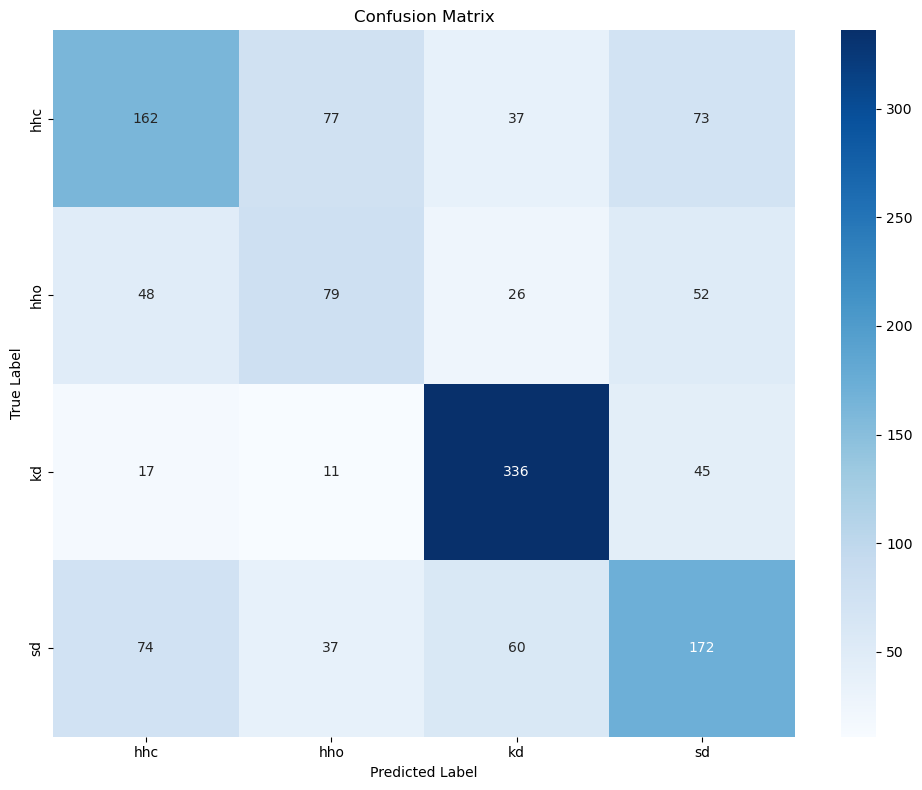



Testing hybrid KNN with adaptation for participant P24

Held out participant's data statistics:
Adaptation set size: 74
Test set size: 74

Label distribution in adaptation set:
hhc    26
hho    18
kd     17
sd     13
Name: count, dtype: int64

Label distribution in test set:
hhc    26
hho    19
kd     16
sd     13
Name: count, dtype: int64

Training base model (excluding held out participant)...

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.870

Base Model Results (before adaptation):

Classification Report:
              precision    recall  f1-score   support

         hhc       0.42      0.42      0.42        26
         hho       0.31      0.42      0.36        19
          kd       1.00      0.44      0.61        16
          sd       0.07      0.08      0.07        13

    accuracy                           0.36        74
   macro avg       0.45      0.34      0.36        74
weighted avg       0.46      0.36   

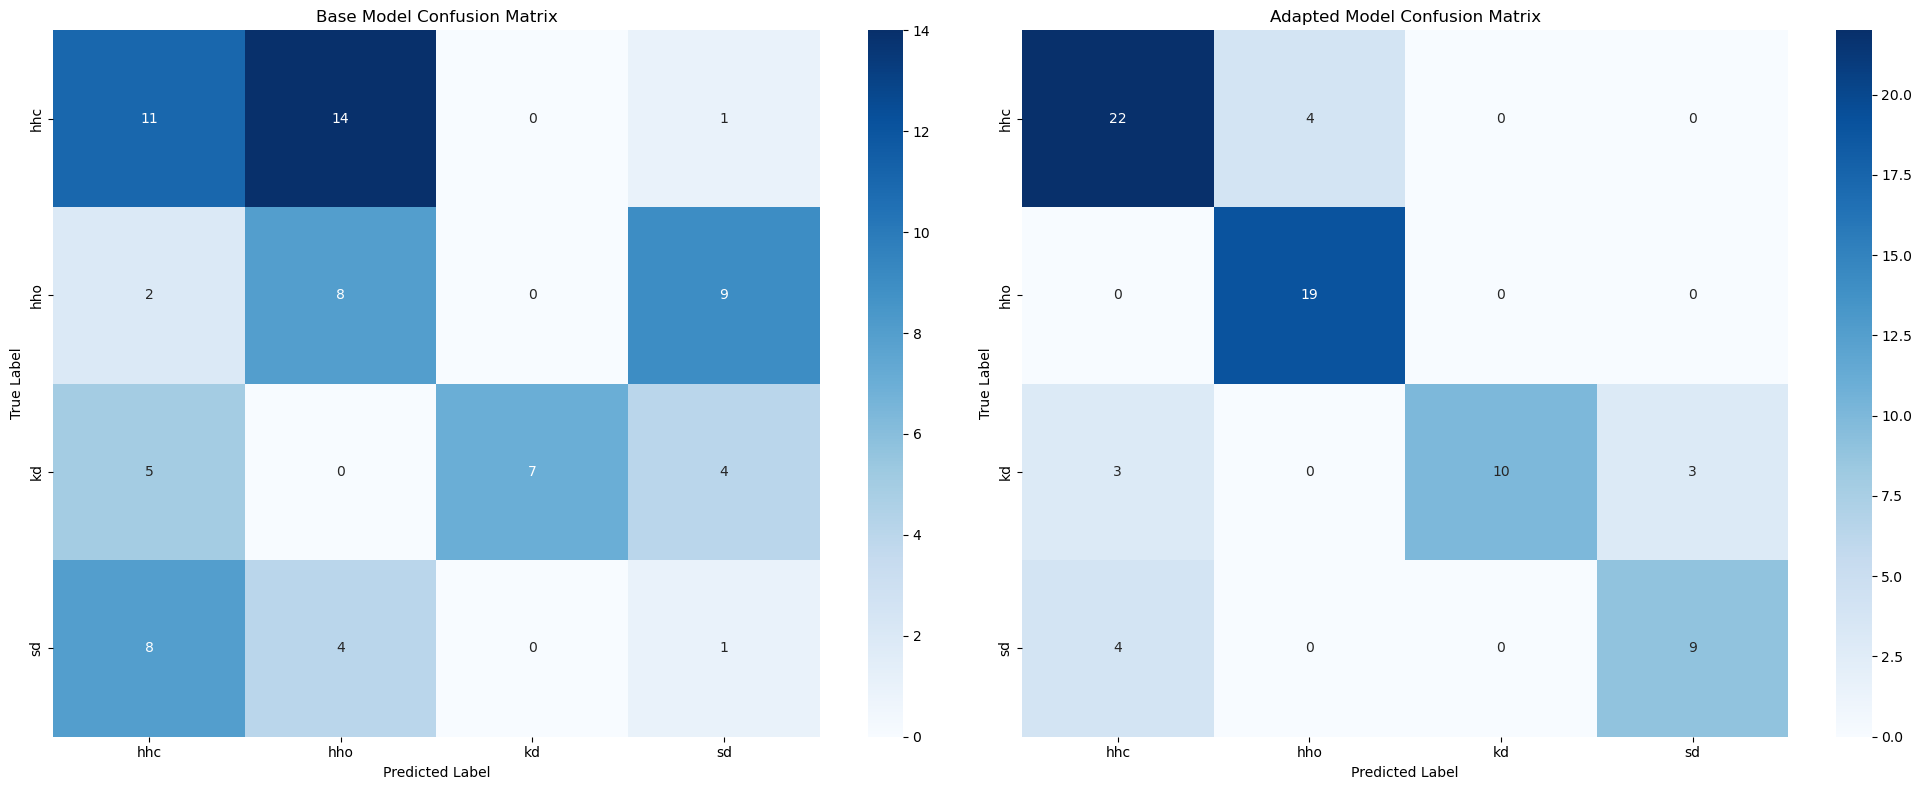

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

def load_features_and_labels(features_path, labels_path, segment_info_path):
    """
    Load features and labels from specified paths.
    """
    X = np.load(features_path)
    y = np.load(labels_path)
    segment_info = pd.read_csv(segment_info_path)
    
    assert len(X) == len(y) == len(segment_info)
    return X, y, segment_info

def train_standard_knn(X, y, segment_info, held_out_participant):
    """
    Train standard KNN model excluding one participant completely.
    
    Args:
        X, y: Features and labels
        segment_info: DataFrame with participant info
        held_out_participant: ID of participant to hold out completely
    """
    print(f"Training standard KNN (excluding participant {held_out_participant})...")
    
    # Exclude held out participant from all data
    mask = segment_info['participant_id'] != held_out_participant
    X_filtered = X[mask]
    y_filtered = y[mask]
    segment_info_filtered = segment_info[mask]
    
    # Get unique participants (excluding held out participant)
    participants = segment_info_filtered['participant_id'].unique()
    
    # Split participants into train and test (80/20 split)
    test_size = 0.2
    n_test_participants = max(1, int(len(participants) * test_size))
    np.random.seed(42)
    test_participants = np.random.choice(participants, n_test_participants, replace=False)
    train_participants = np.array([p for p in participants if p not in test_participants])
    
    # Create train/test masks
    train_mask = segment_info_filtered['participant_id'].isin(train_participants)
    test_mask = segment_info_filtered['participant_id'].isin(test_participants)
    
    # Get train/test data
    X_train = X_filtered[train_mask]
    y_train = y_filtered[train_mask]
    segment_info_train = segment_info_filtered[train_mask]
    
    X_test = X_filtered[test_mask]
    y_test = y_filtered[test_mask]
    
    print(f"\nParticipant-Independent Split Statistics:")
    print(f"Training participants: {sorted(train_participants)}")
    print(f"Test participants: {sorted(test_participants)}")
    print(f"Held out participant: {held_out_participant}")
    print(f"\nTraining set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    print("\nLabel distribution in training set:")
    print(pd.Series(y_train).value_counts())
    print("\nLabel distribution in test set:")
    print(pd.Series(y_test).value_counts())
    
    # Create group IDs for cross-validation
    base_ids = np.array([
        Path(p).stem.replace("_aug" + ''.join(filter(str.isdigit, Path(p).stem)), '')
        for p in segment_info_train['segment_path'].values
    ])
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Encode labels
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)
    print("\nLabel mapping:", dict(zip(le.classes_, range(len(le.classes_)))))
    
    # Define parameter grid
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
    
    knn = KNeighborsClassifier()
    gkf = GroupKFold(n_splits=5)
    
    # Perform grid search with GroupKFold
    grid_search = GridSearchCV(
        knn,
        param_grid,
        cv=gkf.split(X_train_scaled, y_train_enc, groups=base_ids),
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X_train_scaled, y_train_enc)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print("\nCross-validation results:")
    print("Best parameters:", best_params)
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
    
    # Evaluate on test set
    y_pred_enc = best_model.predict(X_test_scaled)
    y_pred = le.inverse_transform(y_pred_enc)
    
    print("\nTest Set Evaluation:")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return best_model, scaler, le

def train_hybrid_knn(X, y, segment_info, held_out_participant):
    """
    Train hybrid KNN model that uses half of held out participant's data.
    
    Args:
        X, y: Features and labels
        segment_info: DataFrame with participant info
        held_out_participant: ID of participant to adapt to
    """
    print(f"\n\n==================================================")
    print(f"Testing hybrid KNN with adaptation for participant {held_out_participant}")
    print(f"==================================================")
    
    # Exclude held out participant from training data
    train_mask = segment_info['participant_id'] != held_out_participant
    X_train = X[train_mask]
    y_train = y[train_mask]
    segment_info_train = segment_info[train_mask]
    
    # Get held out participant's data
    test_mask = segment_info['participant_id'] == held_out_participant
    X_held_out = X[test_mask]
    y_held_out = y[test_mask]
    segment_info_held_out = segment_info[test_mask]
    
    # Split held out participant's data into adaptation and test sets
    X_adapt, X_test, y_adapt, y_test, adapt_indices, test_indices = train_test_split(
        X_held_out, 
        y_held_out,
        np.where(test_mask)[0],
        test_size=0.5,
        stratify=y_held_out,
        random_state=42
    )
    
    print("\nHeld out participant's data statistics:")
    print(f"Adaptation set size: {len(X_adapt)}")
    print(f"Test set size: {len(X_test)}")
    print("\nLabel distribution in adaptation set:")
    print(pd.Series(y_adapt).value_counts())
    print("\nLabel distribution in test set:")
    print(pd.Series(y_test).value_counts())
    
    # Create group IDs for cross-validation
    base_ids = np.array([
        Path(p).stem.replace("_aug" + ''.join(filter(str.isdigit, Path(p).stem)), '')
        for p in segment_info_train['segment_path'].values
    ])
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_adapt_scaled = scaler.transform(X_adapt)
    X_test_scaled = scaler.transform(X_test)
    
    # Encode labels
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_adapt_enc = le.transform(y_adapt)
    y_test_enc = le.transform(y_test)
    
    # Define parameter grid
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
    
    # Initialize KNN and GroupKFold
    knn = KNeighborsClassifier()
    gkf = GroupKFold(n_splits=5)
    
    # Perform grid search with GroupKFold
    grid_search = GridSearchCV(
        knn,
        param_grid,
        cv=gkf.split(X_train_scaled, y_train_enc, groups=base_ids),
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Fit base model
    print("\nTraining base model (excluding held out participant)...")
    grid_search.fit(X_train_scaled, y_train_enc)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print("\nBest parameters:", best_params)
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
    
    y_pred_base_enc = best_model.predict(X_test_scaled)
    y_pred_base = le.inverse_transform(y_pred_base_enc)
    
    print("\nBase Model Results (before adaptation):")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_base))
    
    # Add adaptation data to training
    X_train_adapted = np.vstack([X_train_scaled, X_adapt_scaled])
    y_train_adapted = np.concatenate([y_train_enc, y_adapt_enc])
    
    # Train adapted model
    print("\nTraining adapted model (including half of held out participant's data)...")
    adapted_model = KNeighborsClassifier(**best_params)
    adapted_model.fit(X_train_adapted, y_train_adapted)
    
    y_pred_adapted_enc = adapted_model.predict(X_test_scaled)
    y_pred_adapted = le.inverse_transform(y_pred_adapted_enc)
    
    print("\nAdapted Model Results:")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_adapted))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    cm_base = confusion_matrix(y_test, y_pred_base)
    sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_, ax=ax1)
    ax1.set_title('Base Model Confusion Matrix')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    
    cm_adapted = confusion_matrix(y_test, y_pred_adapted)
    sns.heatmap(cm_adapted, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_, ax=ax2)
    ax2.set_title('Adapted Model Confusion Matrix')
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    return adapted_model, scaler, le

# Example usage
def main():
    features_path = "../../extracted_features/features/mfcc_extracted_features.npy"
    labels_path = "../../extracted_features/labels/mfcc_extracted_labels.npy"
    segment_info_path = "../../segment_info/segment_info.csv"
    
    # Load data
    X, y, segment_info = load_features_and_labels(features_path, labels_path, segment_info_path)
    
    # 1. Train standard KNN excluding one participant completely
    held_out_participant = 'P24'
    standard_model, standard_scaler, standard_le = train_standard_knn(
        X, y, segment_info, held_out_participant
    )
    
    # 2. Train hybrid KNN using half of held out participant's data
    hybrid_model, hybrid_scaler, hybrid_le = train_hybrid_knn(
        X, y, segment_info, held_out_participant
    )

if __name__ == "__main__":
    main()


Testing hybrid KNN with 5 examples per class from participant P24

Held out participant's data statistics:
Adaptation set size: 20
Test set size: 128

Label distribution in adaptation set:
hhc    5
hho    5
kd     5
sd     5
Name: count, dtype: int64

Label distribution in test set:
hhc    47
hho    32
kd     28
sd     21
Name: count, dtype: int64

Training base model (excluding held out participant)...

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.870

Base Model Results (before adaptation):

Classification Report:
              precision    recall  f1-score   support

         hhc       0.51      0.43      0.47        47
         hho       0.27      0.41      0.33        32
          kd       0.93      0.50      0.65        28
          sd       0.12      0.14      0.13        21

    accuracy                           0.39       128
   macro avg       0.46      0.37      0.39       128
weighted avg       0.48      

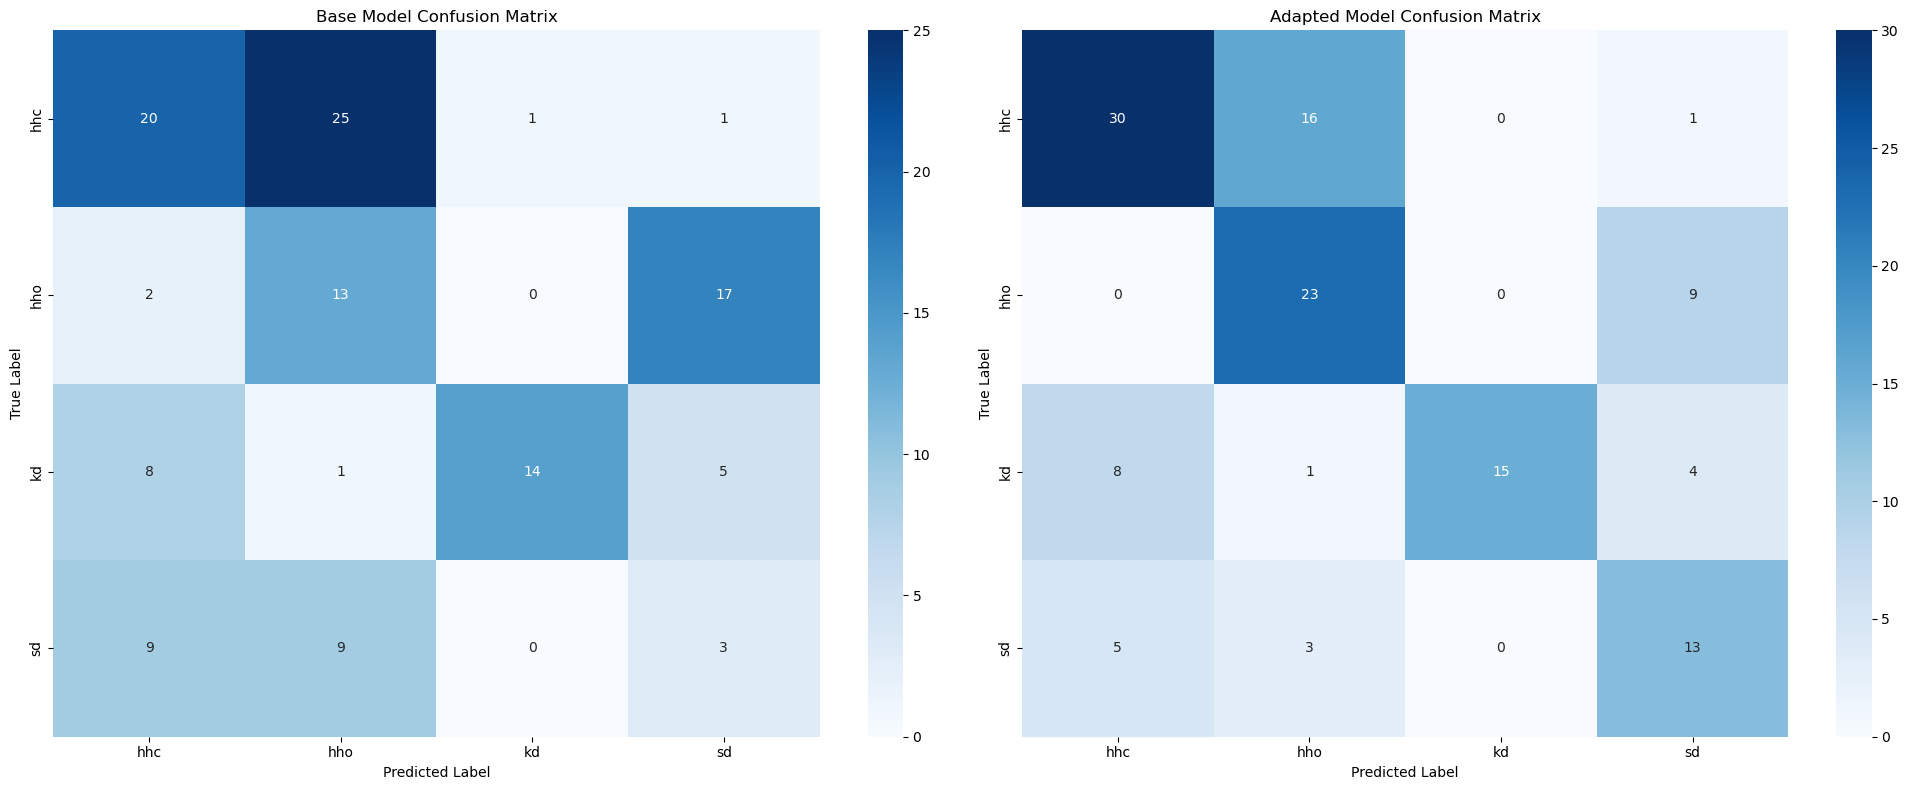


Testing hybrid KNN with 5 examples per class from participant P17

Held out participant's data statistics:
Adaptation set size: 20
Test set size: 124

Label distribution in adaptation set:
hhc    5
hho    5
kd     5
sd     5
Name: count, dtype: int64

Label distribution in test set:
kd     43
hho    41
hhc    20
sd     20
Name: count, dtype: int64

Training base model (excluding held out participant)...

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.875

Base Model Results (before adaptation):

Classification Report:
              precision    recall  f1-score   support

         hhc       0.12      0.25      0.17        20
         hho       0.46      0.44      0.45        41
          kd       0.96      0.58      0.72        43
          sd       0.37      0.35      0.36        20

    accuracy                           0.44       124
   macro avg       0.48      0.41      0.43       124
weighted avg       0.57      

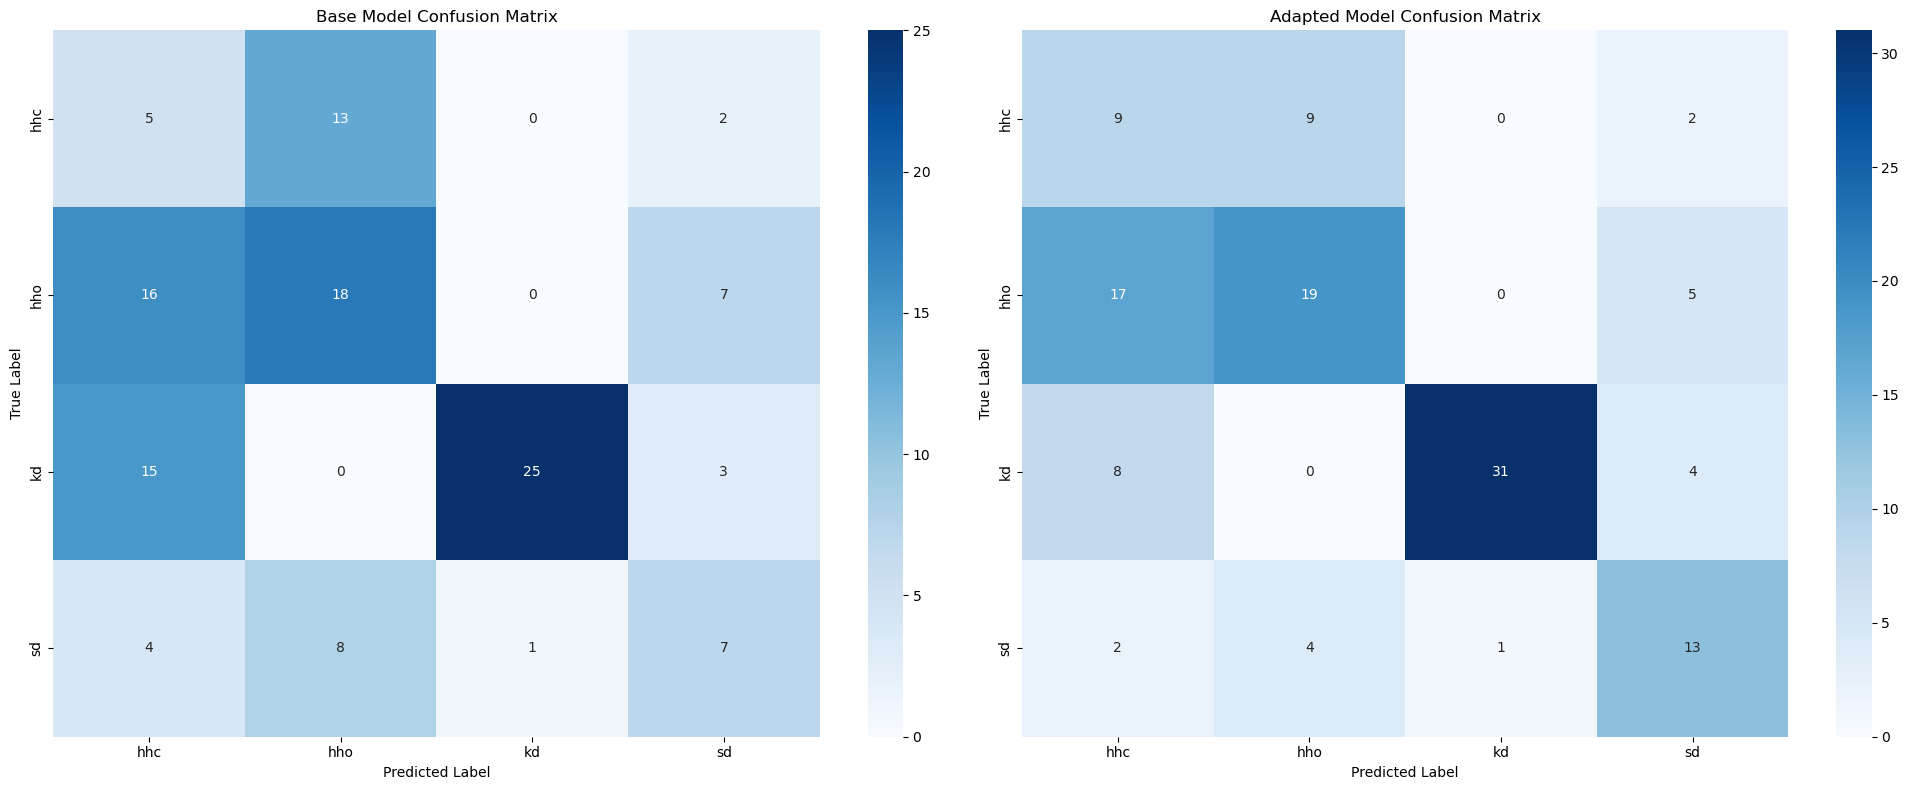


Testing hybrid KNN with 5 examples per class from participant P10

Held out participant's data statistics:
Adaptation set size: 20
Test set size: 148

Label distribution in adaptation set:
hhc    5
hho    5
kd     5
sd     5
Name: count, dtype: int64

Label distribution in test set:
kd     47
sd     40
hhc    32
hho    29
Name: count, dtype: int64

Training base model (excluding held out participant)...

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.872

Base Model Results (before adaptation):

Classification Report:
              precision    recall  f1-score   support

         hhc       0.25      0.09      0.14        32
         hho       0.03      0.03      0.03        29
          kd       0.62      0.60      0.61        47
          sd       0.32      0.47      0.38        40

    accuracy                           0.34       148
   macro avg       0.31      0.30      0.29       148
weighted avg       0.34      

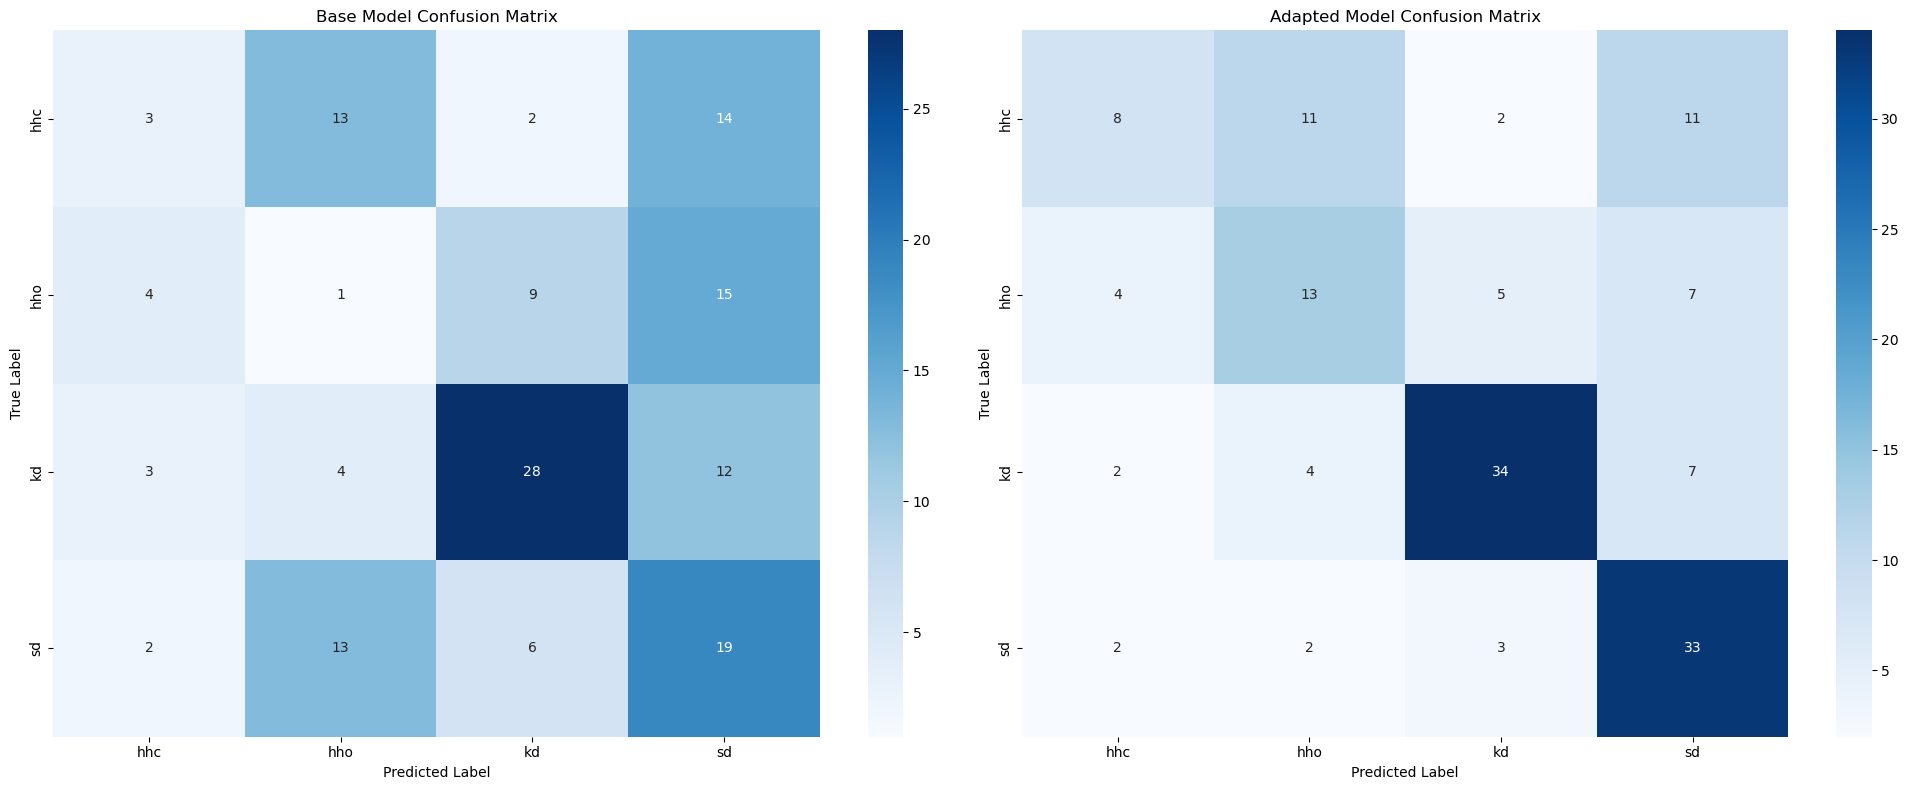

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

def load_features_and_labels(features_path, labels_path, segment_info_path):
    """
    Load features and labels from specified paths.
    """
    X = np.load(features_path)
    y = np.load(labels_path)
    segment_info = pd.read_csv(segment_info_path)
    
    assert len(X) == len(y) == len(segment_info)
    return X, y, segment_info

def train_hybrid_knn_limited_examples(X, y, segment_info, held_out_participant, examples_per_class=5):
    """
    Train hybrid KNN model that uses a limited number of examples from held out participant.
    
    Args:
        X, y: Features and labels
        segment_info: DataFrame with participant info
        held_out_participant: ID of participant to adapt to
        examples_per_class: Number of examples per class to use for adaptation
    """
    print(f"\n==================================================")
    print(f"Testing hybrid KNN with {examples_per_class} examples per class from participant {held_out_participant}")
    print(f"==================================================")
    
    # Exclude held out participant from training data
    train_mask = segment_info['participant_id'] != held_out_participant
    X_train = X[train_mask]
    y_train = y[train_mask]
    segment_info_train = segment_info[train_mask]
    
    # Get held out participant's data
    test_mask = segment_info['participant_id'] == held_out_participant
    X_held_out = X[test_mask]
    y_held_out = y[test_mask]
    segment_info_held_out = segment_info[test_mask]
    
    # Create dataframe for the held-out participant's data
    held_out_df = pd.DataFrame({
        'index': np.where(test_mask)[0],
        'label': y_held_out
    })
    
    adapt_indices = []
    test_indices = []
    
    for label in np.unique(y_held_out):
        label_indices = held_out_df[held_out_df['label'] == label]['index'].values
        
        if len(label_indices) <= examples_per_class * 2:
            n_adapt = len(label_indices) // 2
        else:
            n_adapt = examples_per_class
            
        # Randomly select examples_per_class samples for adaptation
        np.random.seed(42)
        selected_indices = np.random.choice(label_indices, n_adapt, replace=False)
        
        adapt_indices.extend(selected_indices)
        # The rest are for testing
        test_indices.extend([idx for idx in label_indices if idx not in selected_indices])
    
    # Get adaptation and test data
    X_adapt = X[adapt_indices]
    y_adapt = y[adapt_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # Print statistics
    print("\nHeld out participant's data statistics:")
    print(f"Adaptation set size: {len(X_adapt)}")
    print(f"Test set size: {len(X_test)}")
    print("\nLabel distribution in adaptation set:")
    print(pd.Series(y_adapt).value_counts())
    print("\nLabel distribution in test set:")
    print(pd.Series(y_test).value_counts())
    
    # Create group IDs for cross-validation
    base_ids = np.array([
        Path(p).stem.replace("_aug" + ''.join(filter(str.isdigit, Path(p).stem)), '')
        for p in segment_info_train['segment_path'].values
    ])
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_adapt_scaled = scaler.transform(X_adapt)
    X_test_scaled = scaler.transform(X_test)
    
    # Encode labels
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_adapt_enc = le.transform(y_adapt)
    y_test_enc = le.transform(y_test)
    
    # Define parameter grid
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
    
    # Initialize KNN and GroupKFold
    knn = KNeighborsClassifier()
    gkf = GroupKFold(n_splits=5)
    
    # Perform grid search with GroupKFold
    grid_search = GridSearchCV(
        knn,
        param_grid,
        cv=gkf.split(X_train_scaled, y_train_enc, groups=base_ids),
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Fit base model
    print("\nTraining base model (excluding held out participant)...")
    grid_search.fit(X_train_scaled, y_train_enc)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print("\nBest parameters:", best_params)
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
    
    y_pred_base_enc = best_model.predict(X_test_scaled)
    y_pred_base = le.inverse_transform(y_pred_base_enc)
    
    print("\nBase Model Results (before adaptation):")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_base))
    
    # Add adaptation data to training
    X_train_adapted = np.vstack([X_train_scaled, X_adapt_scaled])
    y_train_adapted = np.concatenate([y_train_enc, y_adapt_enc])
    
    # Train adapted model
    print("\nTraining adapted model (including limited examples from held out participant)...")
    adapted_model = KNeighborsClassifier(**best_params)
    adapted_model.fit(X_train_adapted, y_train_adapted)
    
    y_pred_adapted_enc = adapted_model.predict(X_test_scaled)
    y_pred_adapted = le.inverse_transform(y_pred_adapted_enc)
    
    print("\nAdapted Model Results:")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_adapted))
    
    # Calculate improvement
    base_accuracy = np.mean(y_pred_base == y_test)
    adapted_accuracy = np.mean(y_pred_adapted == y_test)
    improvement = (adapted_accuracy - base_accuracy) * 100
    
    print(f"\nImprovement: {improvement:.2f}% (from {base_accuracy:.2%} to {adapted_accuracy:.2%})")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    cm_base = confusion_matrix(y_test, y_pred_base)
    sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_, ax=ax1)
    ax1.set_title('Base Model Confusion Matrix')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    
    cm_adapted = confusion_matrix(y_test, y_pred_adapted)
    sns.heatmap(cm_adapted, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_, ax=ax2)
    ax2.set_title('Adapted Model Confusion Matrix')
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    return adapted_model, scaler, le

# Example usage
def main():
    features_path = "../../extracted_features/features/mfcc_extracted_features.npy"
    labels_path = "../../extracted_features/labels/mfcc_extracted_labels.npy"
    segment_info_path = "../../segment_info/segment_info.csv"
    
    # Load data
    X, y, segment_info = load_features_and_labels(features_path, labels_path, segment_info_path)
    
    # Test with different participants
    test_participants = ['P24', 'P17', 'P10']
    examples_per_class = 5
    
    for participant in test_participants:
        hybrid_model, hybrid_scaler, hybrid_le = train_hybrid_knn_limited_examples(
            X, y, segment_info, participant, examples_per_class
        )

if __name__ == "__main__":
    main()


Comparing all KNN approaches for participant P24

Held out participant's data statistics:
Limited adaptation set size: 20 (5 examples per class)
Half adaptation set size: 73 (half of all examples)
Augmented adaptation set size: 100 (5 per class × 5 versions)
Test set size: 128

Label distribution in limited adaptation set:
hhc    5
hho    5
kd     5
sd     5
Name: count, dtype: int64

Label distribution in test set:
hhc    47
hho    32
kd     28
sd     21
Name: count, dtype: int64

Training base model (excluding held out participant)...

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.870

Training all model variations...

RESULTS SUMMARY
1. Base Model: 39.06%
2. Half-Data Model: 86.72%
3. Limited Samples Model (5 per class): 63.28%
4. Augmented Model: 65.62%
5. Weighted Model: 77.34%
6. Augmented + Weighted Model: 53.12%

1. Base Model:
              precision    recall  f1-score   support

         hhc       0.51      

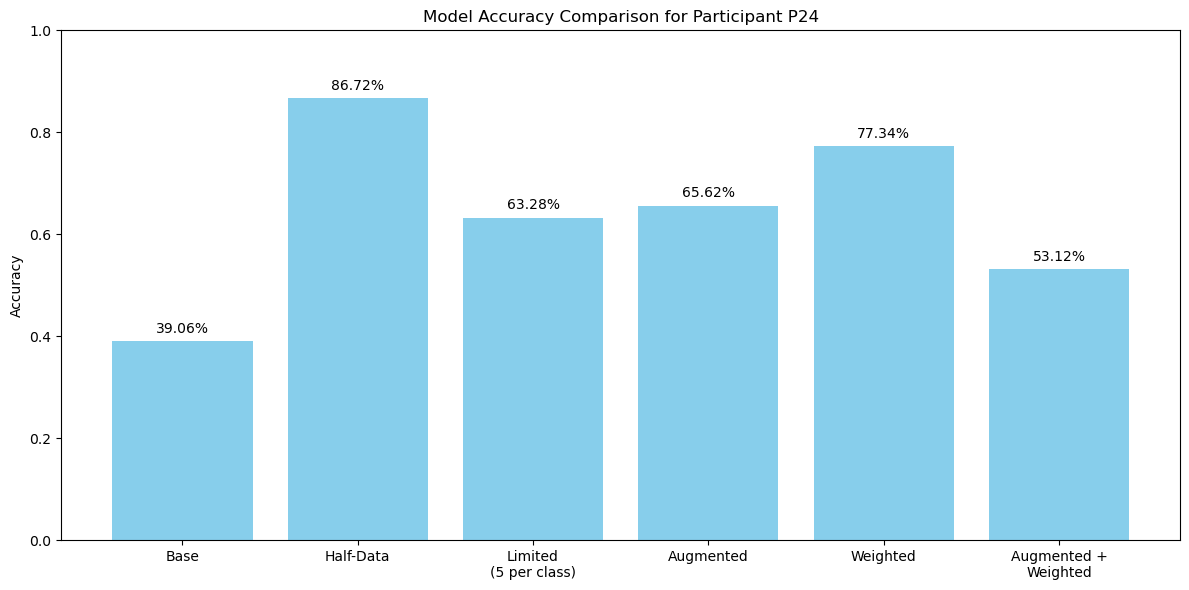


Comparing all KNN approaches for participant P17

Held out participant's data statistics:
Limited adaptation set size: 20 (5 examples per class)
Half adaptation set size: 71 (half of all examples)
Augmented adaptation set size: 100 (5 per class × 5 versions)
Test set size: 124

Label distribution in limited adaptation set:
hhc    5
hho    5
kd     5
sd     5
Name: count, dtype: int64

Label distribution in test set:
kd     43
hho    41
hhc    20
sd     20
Name: count, dtype: int64

Training base model (excluding held out participant)...

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.875

Training all model variations...

RESULTS SUMMARY
1. Base Model: 44.35%
2. Half-Data Model: 83.87%
3. Limited Samples Model (5 per class): 58.06%
4. Augmented Model: 58.06%
5. Weighted Model: 71.77%
6. Augmented + Weighted Model: 37.90%

1. Base Model:
              precision    recall  f1-score   support

         hhc       0.12      

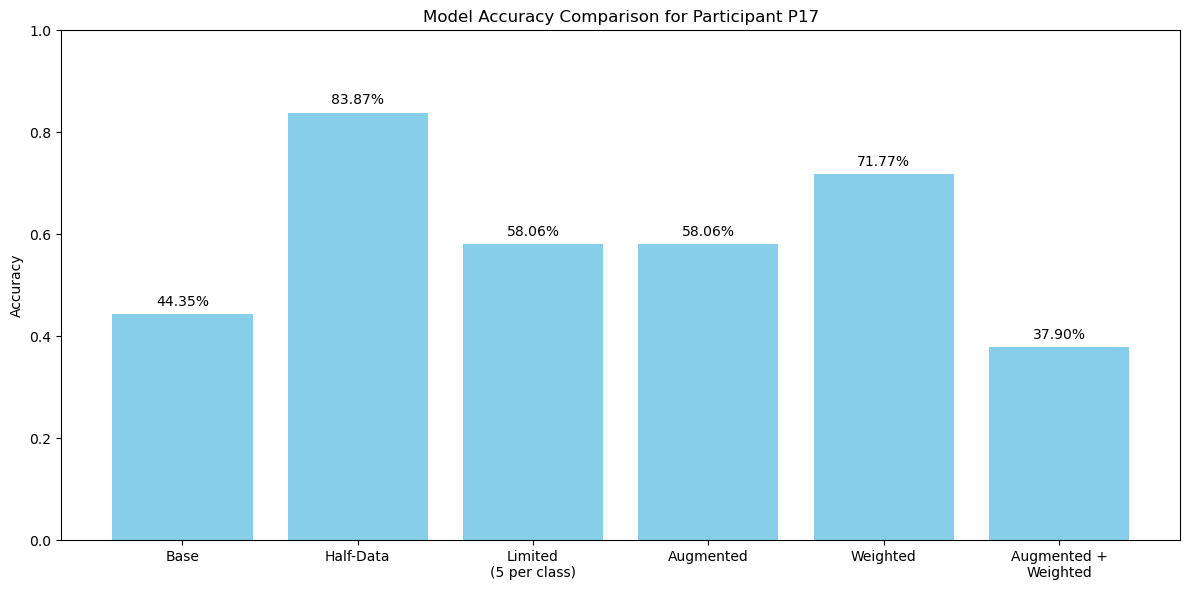


Comparing all KNN approaches for participant P10

Held out participant's data statistics:
Limited adaptation set size: 20 (5 examples per class)
Half adaptation set size: 83 (half of all examples)
Augmented adaptation set size: 100 (5 per class × 5 versions)
Test set size: 148

Label distribution in limited adaptation set:
hhc    5
hho    5
kd     5
sd     5
Name: count, dtype: int64

Label distribution in test set:
kd     47
sd     40
hhc    32
hho    29
Name: count, dtype: int64

Training base model (excluding held out participant)...

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.872

Training all model variations...

RESULTS SUMMARY
1. Base Model: 34.46%
2. Half-Data Model: 89.19%
3. Limited Samples Model (5 per class): 59.46%
4. Augmented Model: 62.16%
5. Weighted Model: 80.41%
6. Augmented + Weighted Model: 42.57%

1. Base Model:
              precision    recall  f1-score   support

         hhc       0.25      

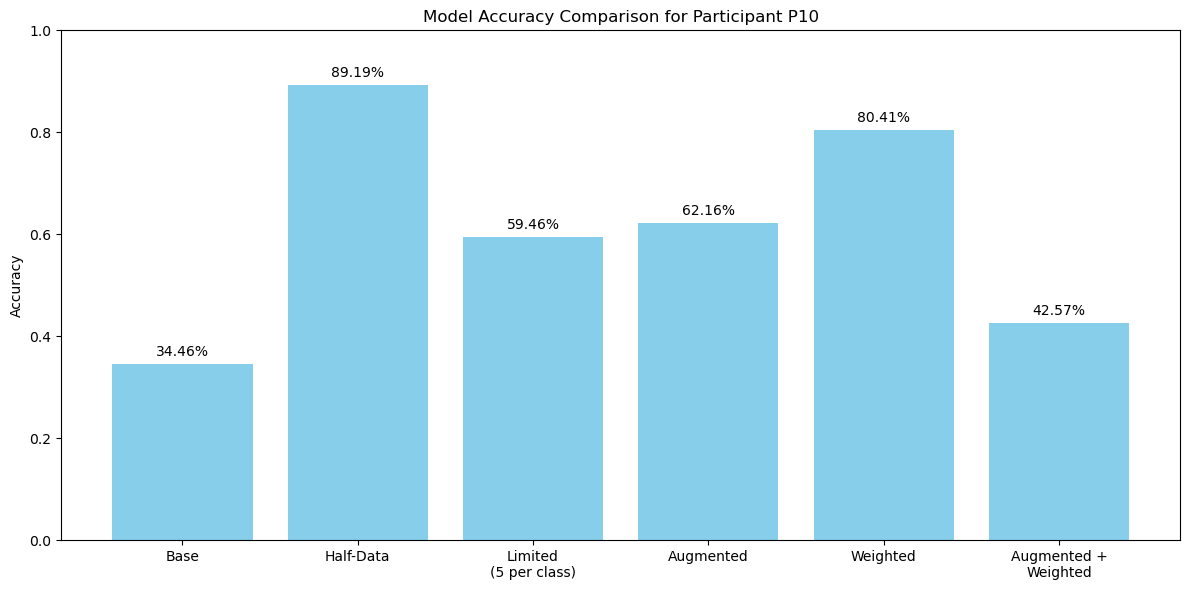

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

def load_features_and_labels(features_path, labels_path, segment_info_path):
    """
    Load features and labels from specified paths.
    """
    X = np.load(features_path)
    y = np.load(labels_path)
    segment_info = pd.read_csv(segment_info_path)
    
    assert len(X) == len(y) == len(segment_info)
    return X, y, segment_info

def augment_features(X, n_augmentations=4):
    """
    Create augmented versions of features with small random variations.
    
    Args:
        X: Feature matrix to augment
        n_augmentations: Number of augmented versions to create per sample
        
    Returns:
        Augmented feature matrix
    """
    n_samples, n_features = X.shape
    X_augmented = np.zeros((n_samples * (n_augmentations + 1), n_features))
    
    # Add original samples
    X_augmented[:n_samples] = X
    
    # Create augmented versions
    np.random.seed(42)
    for i in range(n_augmentations):
        # Add small random variations (±5% of the feature value)
        noise_factor = 0.05
        noise = np.random.normal(0, noise_factor, (n_samples, n_features))
        X_augmented[(i+1)*n_samples:(i+2)*n_samples] = X * (1 + noise)
    
    return X_augmented

def create_weighted_knn(X_train, y_train, X_user, y_user, weight_factor=5.0, **knn_params):
    """
    Create a KNN model where user examples have extra weight by repeating them.
    
    Args:
        X_train: Training features
        y_train: Training labels
        X_user: User examples features
        y_user: User examples labels
        weight_factor: How many times to repeat user examples
        knn_params: Parameters for KNeighborsClassifier
        
    Returns:
        Trained KNN model
    """
    # Repeat user examples to give them more weight
    n_repeats = int(weight_factor)
    X_user_repeated = np.repeat(X_user, n_repeats, axis=0)
    y_user_repeated = np.repeat(y_user, n_repeats)
    
    # Combine with training data
    X_combined = np.vstack([X_train, X_user_repeated])
    y_combined = np.concatenate([y_train, y_user_repeated])
    
    # Create and train KNN
    knn = KNeighborsClassifier(**knn_params)
    knn.fit(X_combined, y_combined)
    
    return knn

def compare_all_knn_approaches(X, y, segment_info, held_out_participant, examples_per_class=5):
    """
    Compare all KNN approaches:
    1. Base model (no participant data)
    2. Half-data model (half of participant's data)
    3. Limited samples model (5 samples per class)
    4. Augmented model (5 samples per class + augmentation)
    5. Weighted model (5 samples per class with extra weight)
    6. Augmented + Weighted model
    
    Args:
        X, y: Features and labels
        segment_info: DataFrame with participant info
        held_out_participant: ID of participant to adapt to
        examples_per_class: Number of examples per class to use for adaptation
    """
    
    # Exclude held out participant from training data
    train_mask = segment_info['participant_id'] != held_out_participant
    X_train = X[train_mask]
    y_train = y[train_mask]
    segment_info_train = segment_info[train_mask]
    
    # Get held out participant's data
    test_mask = segment_info['participant_id'] == held_out_participant
    X_held_out = X[test_mask]
    y_held_out = y[test_mask]
    
    held_out_df = pd.DataFrame({
        'index': np.where(test_mask)[0],
        'label': y_held_out
    })
    
    # Get adaptation indices (5 examples per class)
    adapt_indices = []
    test_indices = []
    
    for label in np.unique(y_held_out):
        label_indices = held_out_df[held_out_df['label'] == label]['index'].values
        
        if len(label_indices) <= examples_per_class * 2:
            n_adapt = len(label_indices) // 2
        else:
            n_adapt = examples_per_class
            
        # Randomly select examples_per_class samples for adaptation
        np.random.seed(42)
        selected_indices = np.random.choice(label_indices, n_adapt, replace=False)
        
        adapt_indices.extend(selected_indices)
        # The rest are for testing
        test_indices.extend([idx for idx in label_indices if idx not in selected_indices])
    
    # Get adaptation and test data
    X_adapt = X[adapt_indices]
    y_adapt = y[adapt_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # For half-data approach, split held out participant into two halves
    half_adapt_indices = []
    half_test_indices = []
    
    for label in np.unique(y_held_out):
        label_indices = held_out_df[held_out_df['label'] == label]['index'].values
        np.random.seed(42)
        np.random.shuffle(label_indices)
        split_idx = len(label_indices) // 2
        
        half_adapt_indices.extend(label_indices[:split_idx])
        half_test_indices.extend(label_indices[split_idx:])
    
    X_half_adapt = X[half_adapt_indices]
    y_half_adapt = y[half_adapt_indices]
    
    # Create augmented versions of adaptation data
    X_adapt_augmented = augment_features(X_adapt, n_augmentations=4)  # 5x data (original + 4 augmented)
    y_adapt_augmented = np.repeat(y_adapt, 5)
    
    print("\nHeld out participant's data statistics:")
    print(f"Limited adaptation set size: {len(X_adapt)} (5 examples per class)")
    print(f"Half adaptation set size: {len(X_half_adapt)} (half of all examples)")
    print(f"Augmented adaptation set size: {len(X_adapt_augmented)} (5 per class × 5 versions)")
    print(f"Test set size: {len(X_test)}")
    
    print("\nLabel distribution in limited adaptation set:")
    print(pd.Series(y_adapt).value_counts())
    
    print("\nLabel distribution in test set:")
    print(pd.Series(y_test).value_counts())
    
    # Create group IDs for cross-validation
    base_ids = np.array([
        Path(p).stem.replace("_aug" + ''.join(filter(str.isdigit, Path(p).stem)), '')
        for p in segment_info_train['segment_path'].values
    ])
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_adapt_scaled = scaler.transform(X_adapt)
    X_half_adapt_scaled = scaler.transform(X_half_adapt)
    X_adapt_augmented_scaled = scaler.transform(X_adapt_augmented)
    X_test_scaled = scaler.transform(X_test)
    
    # Encode labels
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_adapt_enc = le.transform(y_adapt)
    y_half_adapt_enc = le.transform(y_half_adapt)
    y_adapt_augmented_enc = le.transform(y_adapt_augmented)
    y_test_enc = le.transform(y_test)
    
    # Define parameter grid
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
    
    # Initialize KNN and GroupKFold
    knn = KNeighborsClassifier()
    gkf = GroupKFold(n_splits=5)
    
    # Perform grid search with GroupKFold
    grid_search = GridSearchCV(
        knn,
        param_grid,
        cv=gkf.split(X_train_scaled, y_train_enc, groups=base_ids),
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Fit base model
    print("\nTraining base model (excluding held out participant)...")
    grid_search.fit(X_train_scaled, y_train_enc)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print("\nBest parameters:", best_params)
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
    
    base_preds = le.inverse_transform(best_model.predict(X_test_scaled))
    base_acc = accuracy_score(y_test, base_preds)
    
    print("\nTraining all model variations...")
    
    # 2. Half-data model
    half_data_model = KNeighborsClassifier(**best_params)
    X_train_half = np.vstack([X_train_scaled, X_half_adapt_scaled])
    y_train_half = np.concatenate([y_train_enc, y_half_adapt_enc])
    half_data_model.fit(X_train_half, y_train_half)
    half_data_preds = le.inverse_transform(half_data_model.predict(X_test_scaled))
    half_data_acc = accuracy_score(y_test, half_data_preds)
    
    # 3. Limited samples model (5 samples per class)
    limited_model = KNeighborsClassifier(**best_params)
    X_train_limited = np.vstack([X_train_scaled, X_adapt_scaled])
    y_train_limited = np.concatenate([y_train_enc, y_adapt_enc])
    limited_model.fit(X_train_limited, y_train_limited)
    limited_preds = le.inverse_transform(limited_model.predict(X_test_scaled))
    limited_acc = accuracy_score(y_test, limited_preds)
    
    # 4. Augmented model
    augmented_model = KNeighborsClassifier(**best_params)
    X_train_augmented = np.vstack([X_train_scaled, X_adapt_augmented_scaled])
    y_train_augmented = np.concatenate([y_train_enc, y_adapt_augmented_enc])
    augmented_model.fit(X_train_augmented, y_train_augmented)
    augmented_preds = le.inverse_transform(augmented_model.predict(X_test_scaled))
    augmented_acc = accuracy_score(y_test, augmented_preds)
    
    # 5. Weighted model (5 samples per class with extra weight)
    weighted_model = create_weighted_knn(X_train_scaled, y_train_enc, X_adapt_scaled, y_adapt_enc, 
                                         weight_factor=5.0, **best_params)
    weighted_preds = le.inverse_transform(weighted_model.predict(X_test_scaled))
    weighted_acc = accuracy_score(y_test, weighted_preds)
    
    # 6. Augmented + Weighted model
    aug_weighted_model = create_weighted_knn(X_train_scaled, y_train_enc, X_adapt_augmented_scaled, 
                                            y_adapt_augmented_enc, weight_factor=2.0, **best_params)
    aug_weighted_preds = le.inverse_transform(aug_weighted_model.predict(X_test_scaled))
    aug_weighted_acc = accuracy_score(y_test, aug_weighted_preds)
    
    # Print all results
    print("RESULTS SUMMARY")
    print("==================================================")
    print(f"1. Base Model: {base_acc:.2%}")
    print(f"2. Half-Data Model: {half_data_acc:.2%}")
    print(f"3. Limited Samples Model (5 per class): {limited_acc:.2%}")
    print(f"4. Augmented Model: {augmented_acc:.2%}")
    print(f"5. Weighted Model: {weighted_acc:.2%}")
    print(f"6. Augmented + Weighted Model: {aug_weighted_acc:.2%}")
    
    # Print detailed classification reports
    print("\n1. Base Model:")
    print(classification_report(y_test, base_preds))
    
    print("\n2. Half-Data Model:")
    print(classification_report(y_test, half_data_preds))
    
    print("\n3. Limited Samples Model (5 per class):")
    print(classification_report(y_test, limited_preds))
    
    print("\n4. Augmented Model:")
    print(classification_report(y_test, augmented_preds))
    
    print("\n5. Weighted Model:")
    print(classification_report(y_test, weighted_preds))
    
    print("\n6. Augmented + Weighted Model:")
    print(classification_report(y_test, aug_weighted_preds))
    
    # Visualize results
    models = ['Base', 'Half-Data', 'Limited\n(5 per class)', 'Augmented', 'Weighted', 'Augmented +\nWeighted']
    accuracies = [base_acc, half_data_acc, limited_acc, augmented_acc, weighted_acc, aug_weighted_acc]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(models, accuracies, color='skyblue')
    plt.ylim(0, 1.0)
    plt.ylabel('Accuracy')
    plt.title(f'Model Accuracy Comparison for Participant {held_out_participant}')
    
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.2%}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Return all models
    return {
        'base': best_model,
        'half_data': half_data_model,
        'limited': limited_model,
        'augmented': augmented_model,
        'weighted': weighted_model,
        'aug_weighted': aug_weighted_model
    }

# Example usage
def main():
    features_path = "../../extracted_features/features/mfcc_extracted_features.npy"
    labels_path = "../../extracted_features/labels/mfcc_extracted_labels.npy"
    segment_info_path = "../../segment_info/segment_info.csv"
    
    # Load data
    X, y, segment_info = load_features_and_labels(features_path, labels_path, segment_info_path)
    
    # Test with different participants
    test_participants = ['P24', 'P17', 'P10']
    examples_per_class = 5
    
    all_results = {}
    for participant in test_participants:
        models = compare_all_knn_approaches(
            X, y, segment_info, participant, examples_per_class
        )
        all_results[participant] = models

if __name__ == "__main__":
    main()


Tuning weight factor for participant P24

Held out participant's data statistics:
Adaptation set size: 20 (5 examples per class)
Test set size: 128

Label distribution in adaptation set:
hhc    5
hho    5
kd     5
sd     5
Name: count, dtype: int64

Label distribution in test set:
hhc    47
hho    32
kd     28
sd     21
Name: count, dtype: int64

Training base model (excluding held out participant)...

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.870

Testing different weight factors...
Weight factor 1: 63.28%
Weight factor 2: 73.44%
Weight factor 3: 77.34%
Weight factor 5: 77.34%
Weight factor 8: 77.34%
Weight factor 10: 77.34%
Weight factor 15: 77.34%
Weight factor 20: 77.34%
Weight factor 30: 77.34%
Weight factor 50: 77.34%

Best weight factor: 3 with accuracy: 77.34%

Detailed classification report for best weight factor:
              precision    recall  f1-score   support

         hhc       0.80      0.79     

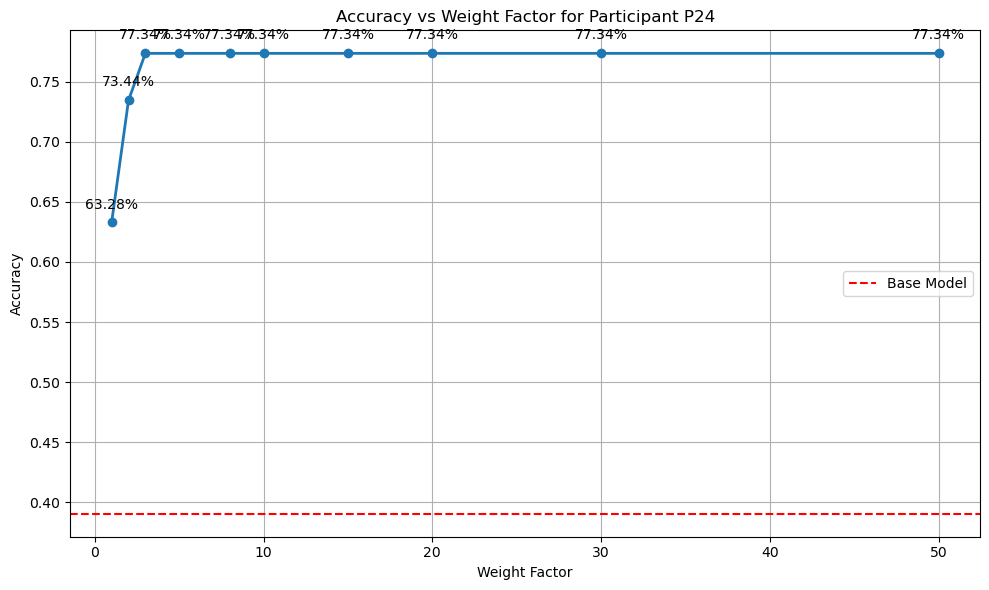

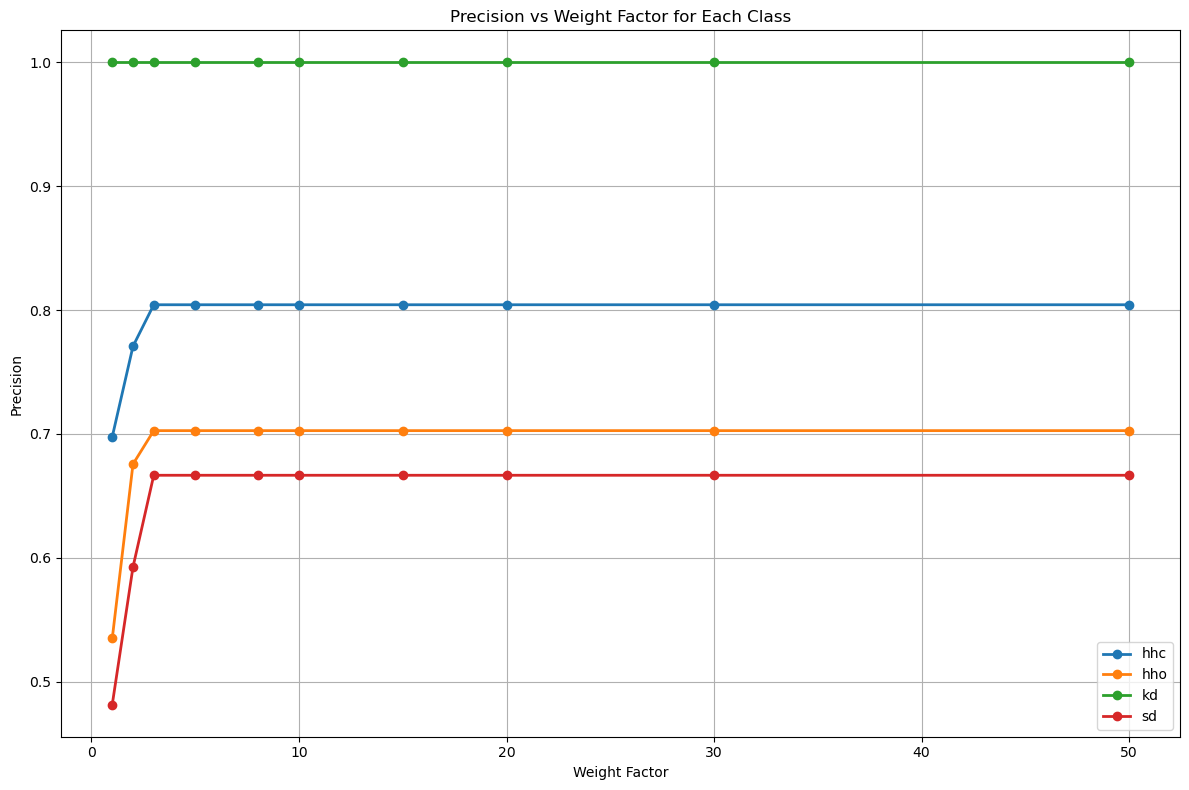

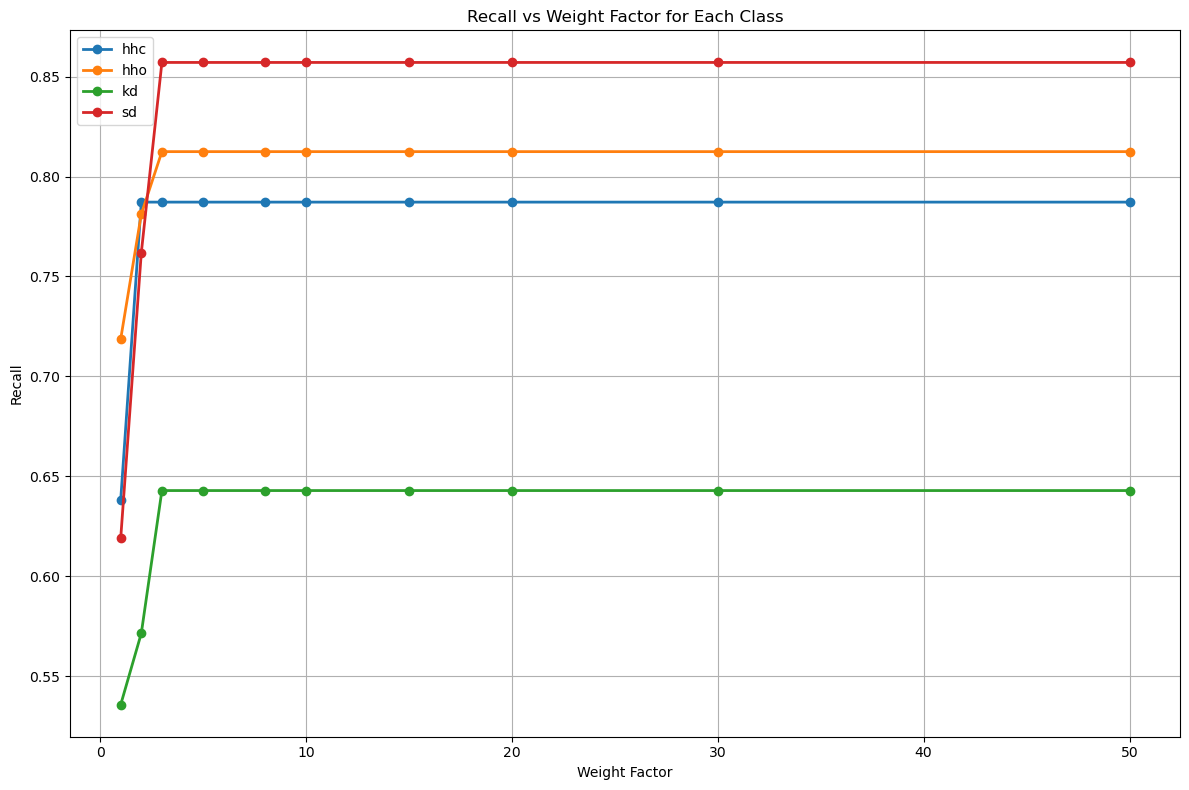

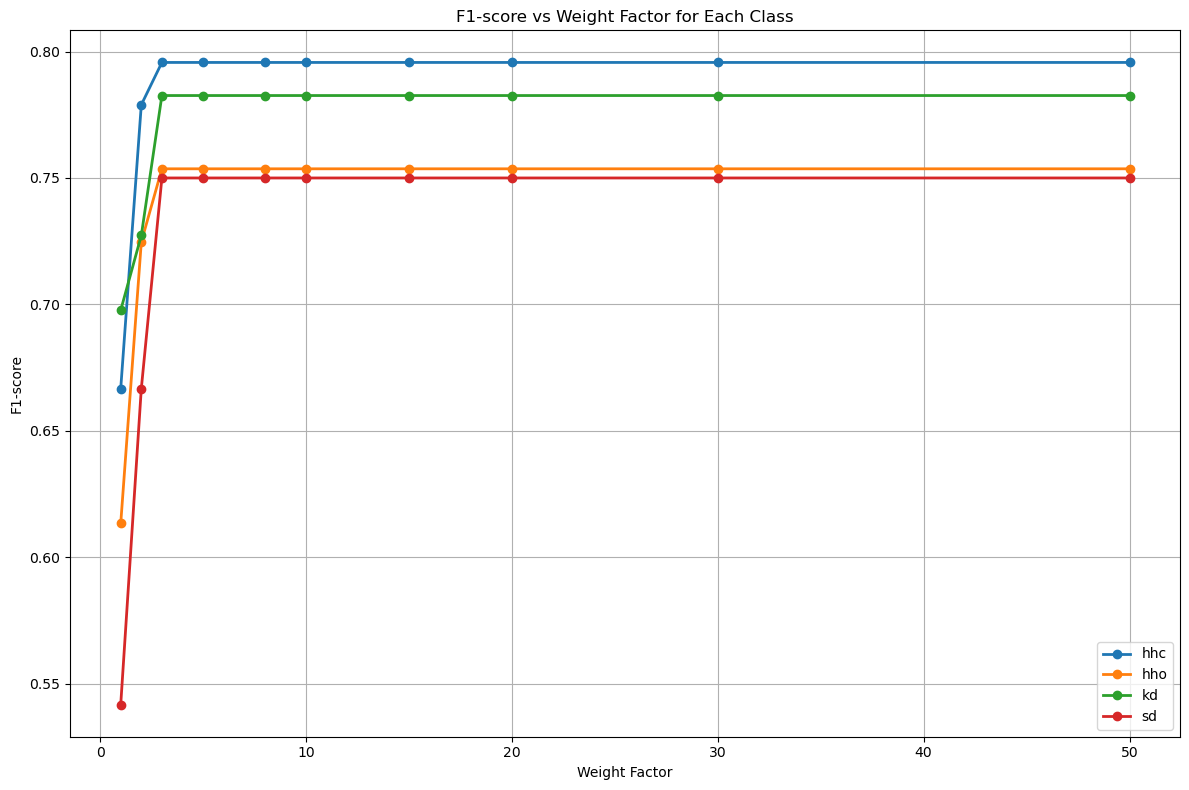


Tuning weight factor for participant P17

Held out participant's data statistics:
Adaptation set size: 20 (5 examples per class)
Test set size: 124

Label distribution in adaptation set:
hhc    5
hho    5
kd     5
sd     5
Name: count, dtype: int64

Label distribution in test set:
kd     43
hho    41
hhc    20
sd     20
Name: count, dtype: int64

Training base model (excluding held out participant)...

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.875

Testing different weight factors...
Weight factor 1: 58.06%
Weight factor 2: 67.74%
Weight factor 3: 71.77%
Weight factor 5: 71.77%
Weight factor 8: 71.77%
Weight factor 10: 71.77%
Weight factor 15: 71.77%
Weight factor 20: 71.77%
Weight factor 30: 71.77%
Weight factor 50: 71.77%

Best weight factor: 3 with accuracy: 71.77%

Detailed classification report for best weight factor:
              precision    recall  f1-score   support

         hhc       0.46      0.80     

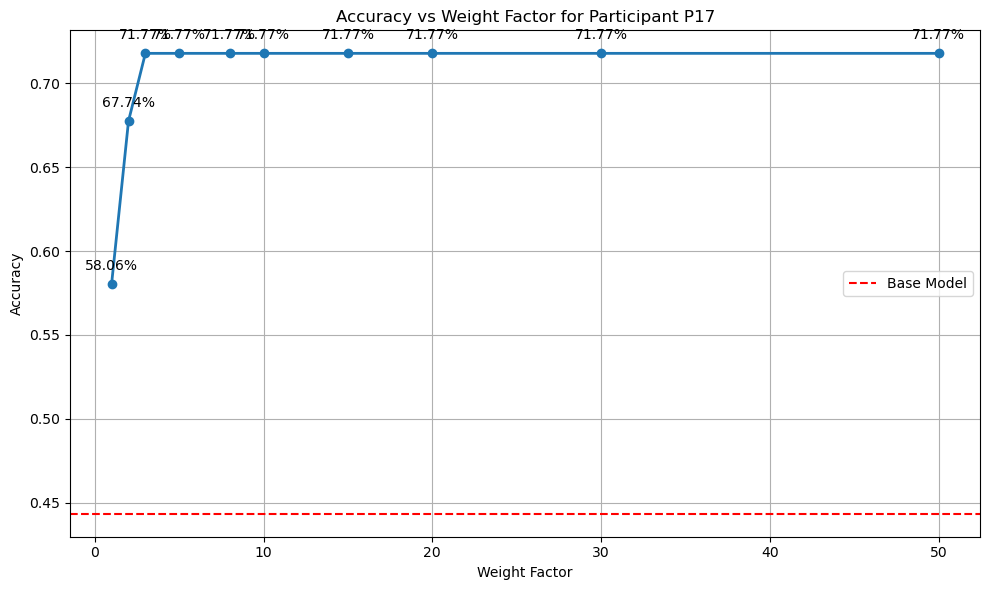

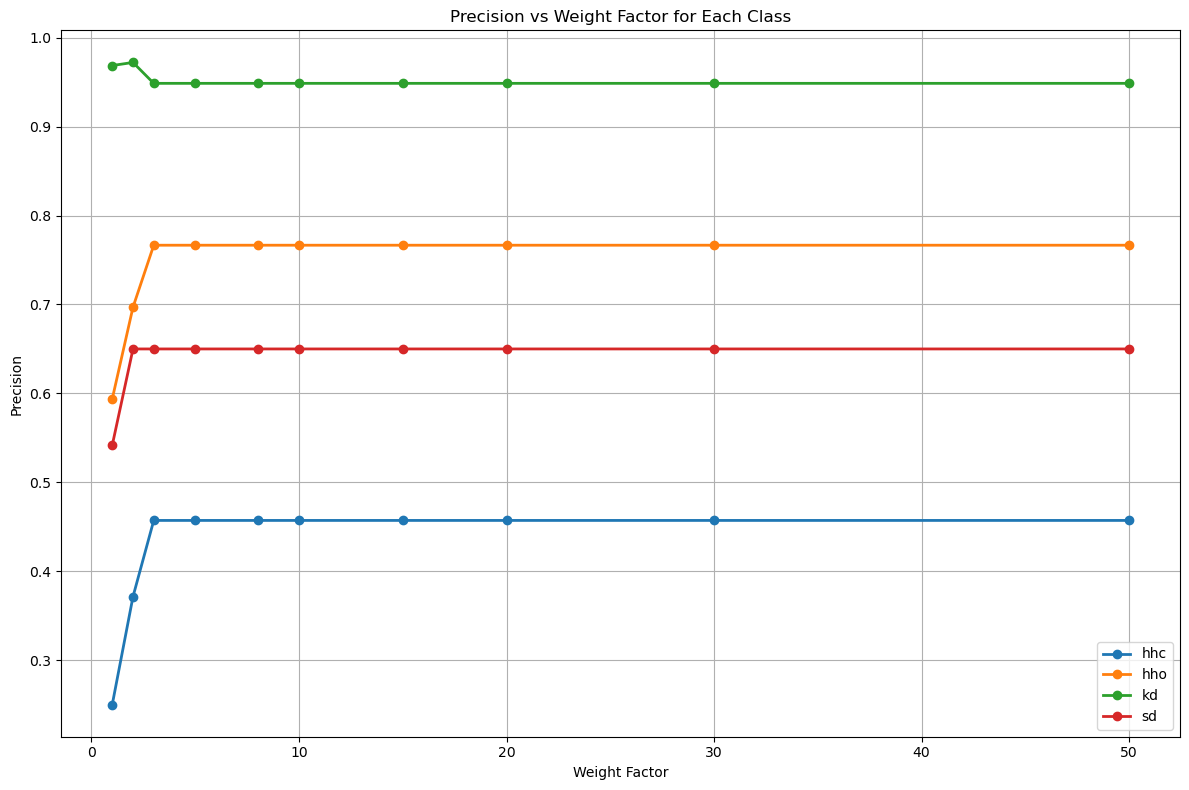

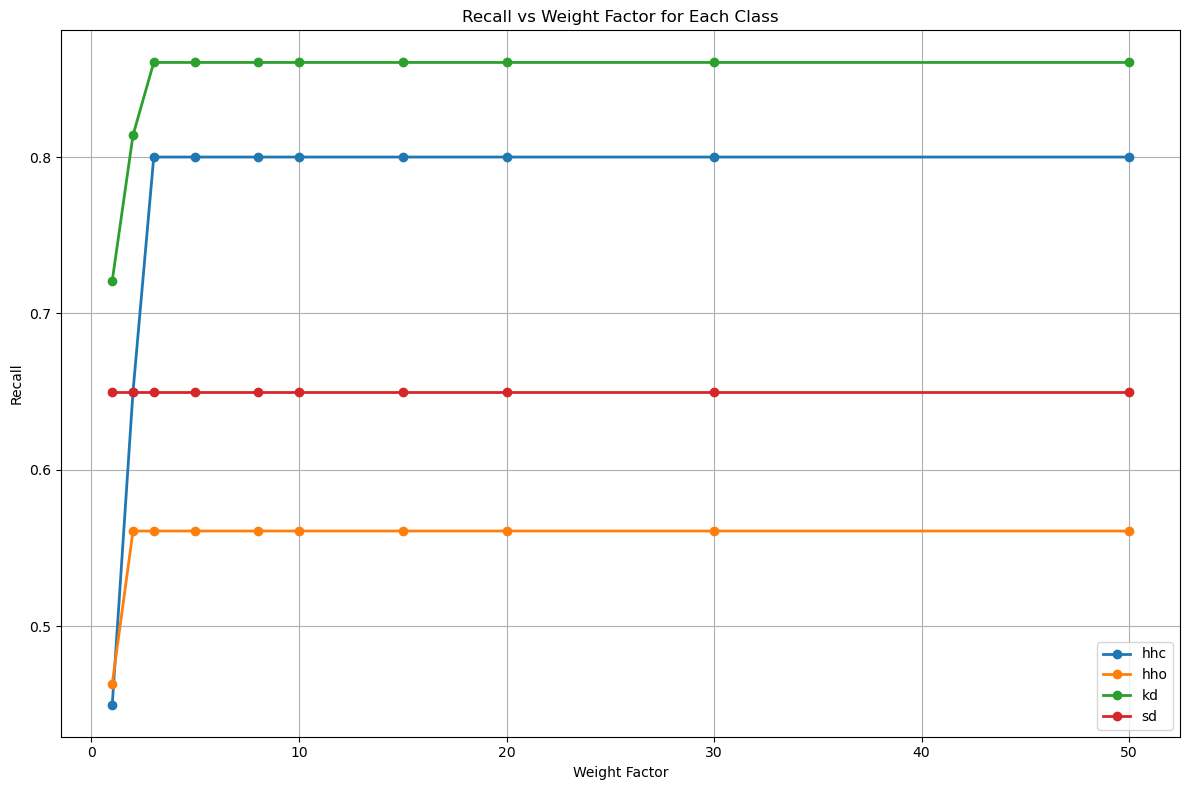

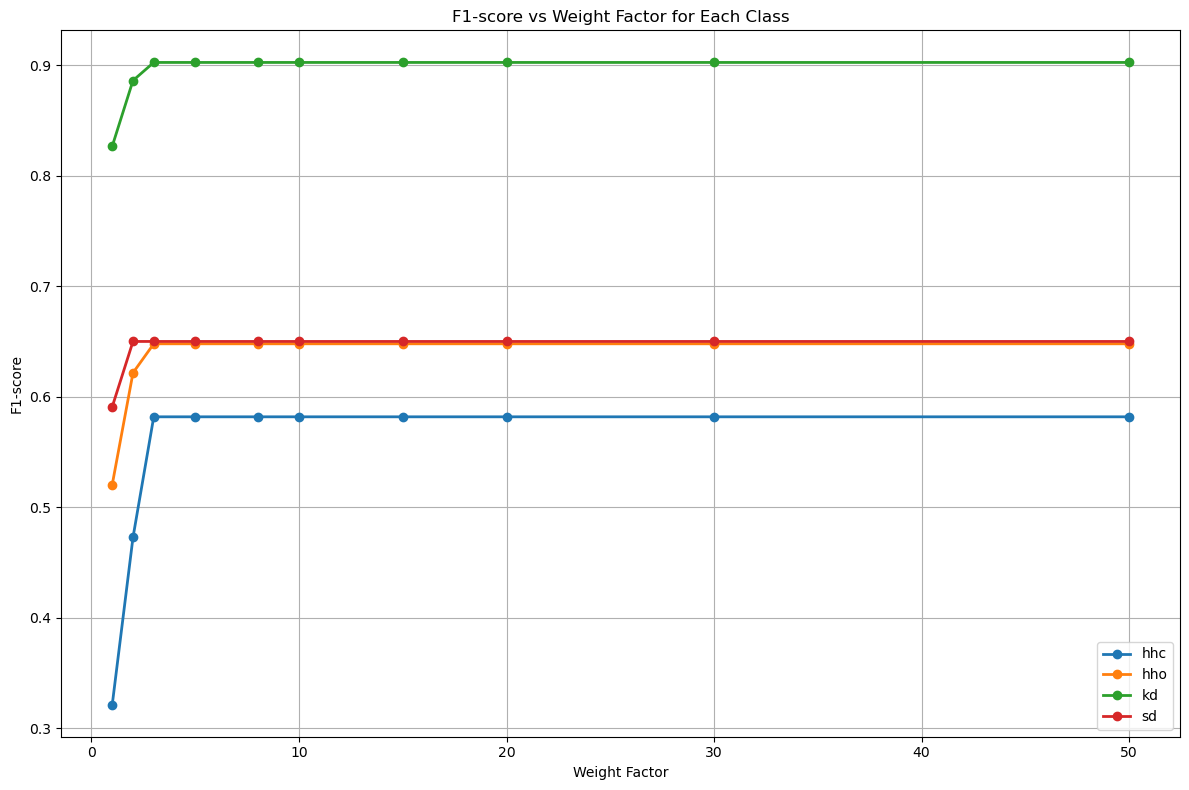


Tuning weight factor for participant P10

Held out participant's data statistics:
Adaptation set size: 20 (5 examples per class)
Test set size: 148

Label distribution in adaptation set:
hhc    5
hho    5
kd     5
sd     5
Name: count, dtype: int64

Label distribution in test set:
kd     47
sd     40
hhc    32
hho    29
Name: count, dtype: int64

Training base model (excluding held out participant)...

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.872

Testing different weight factors...
Weight factor 1: 59.46%
Weight factor 2: 72.97%
Weight factor 3: 80.41%
Weight factor 5: 80.41%
Weight factor 8: 80.41%
Weight factor 10: 80.41%
Weight factor 15: 80.41%
Weight factor 20: 80.41%
Weight factor 30: 80.41%
Weight factor 50: 80.41%

Best weight factor: 3 with accuracy: 80.41%

Detailed classification report for best weight factor:
              precision    recall  f1-score   support

         hhc       0.83      0.62     

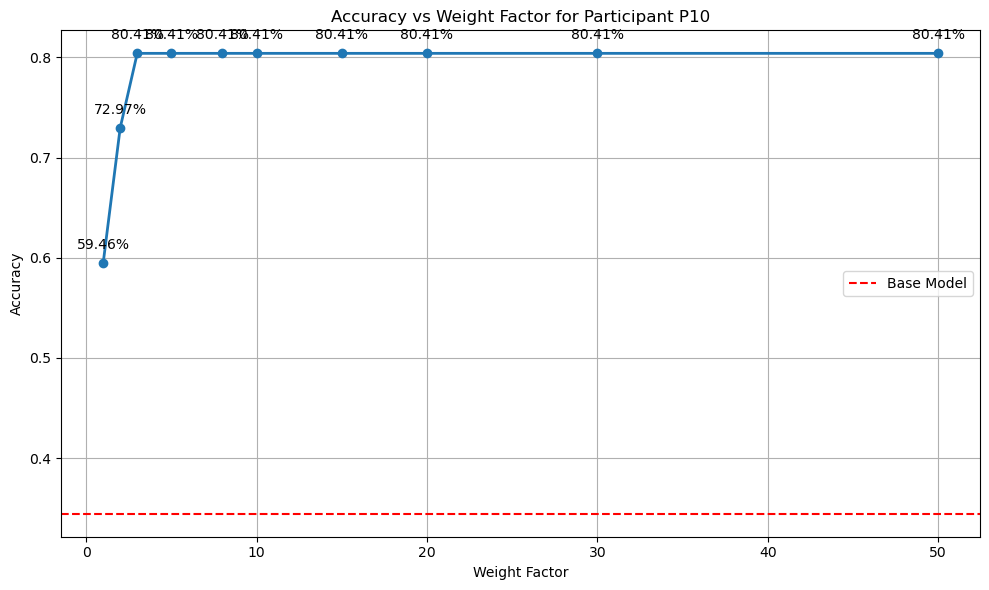

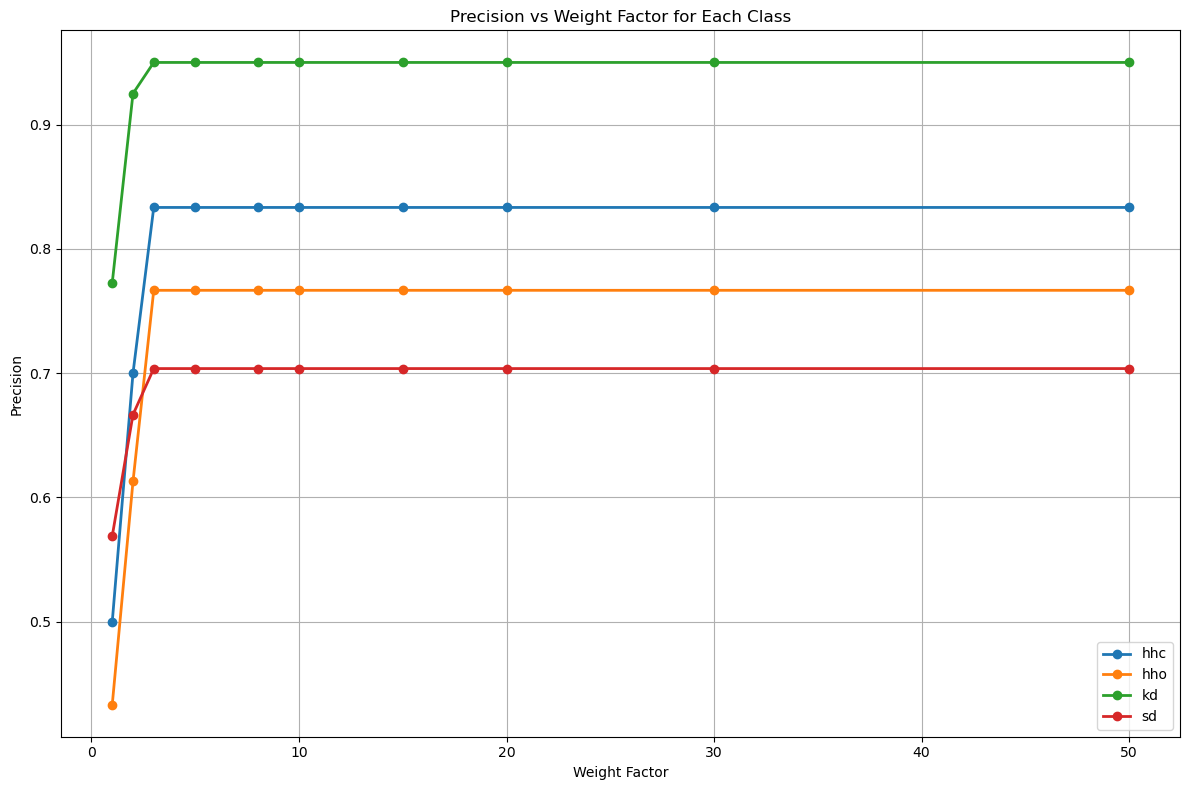

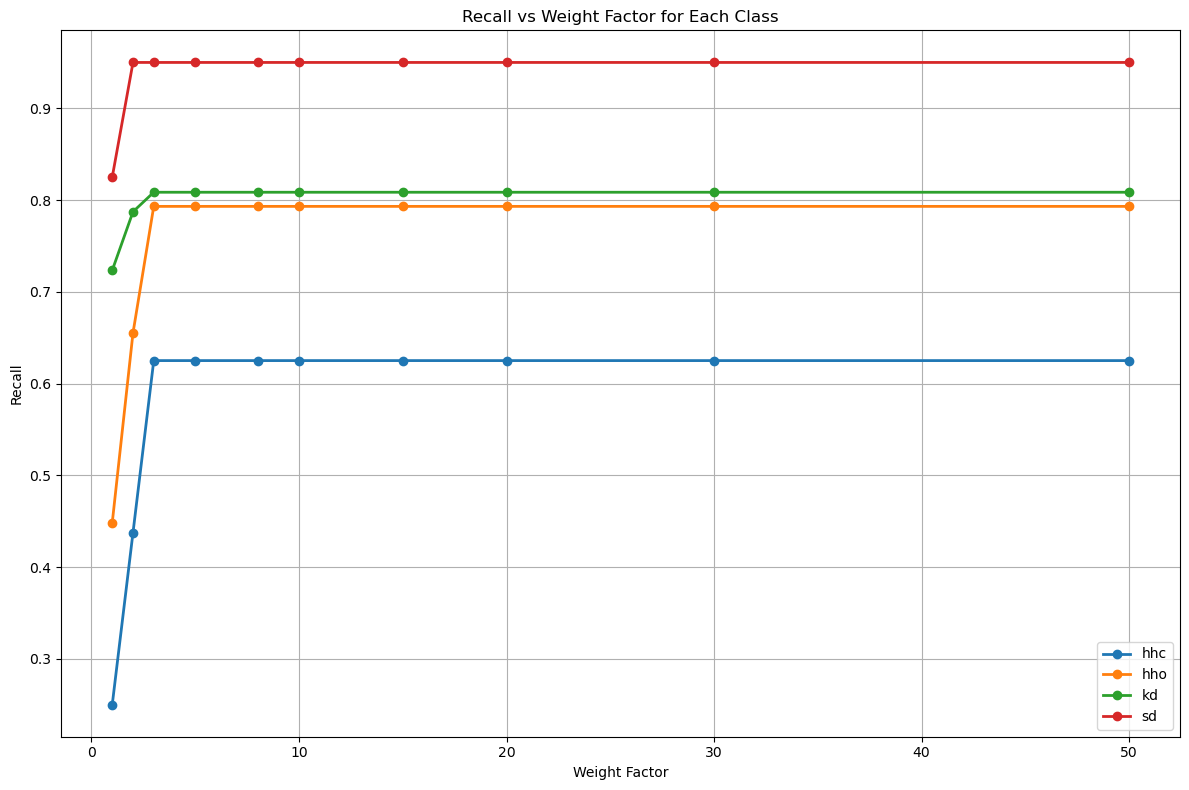

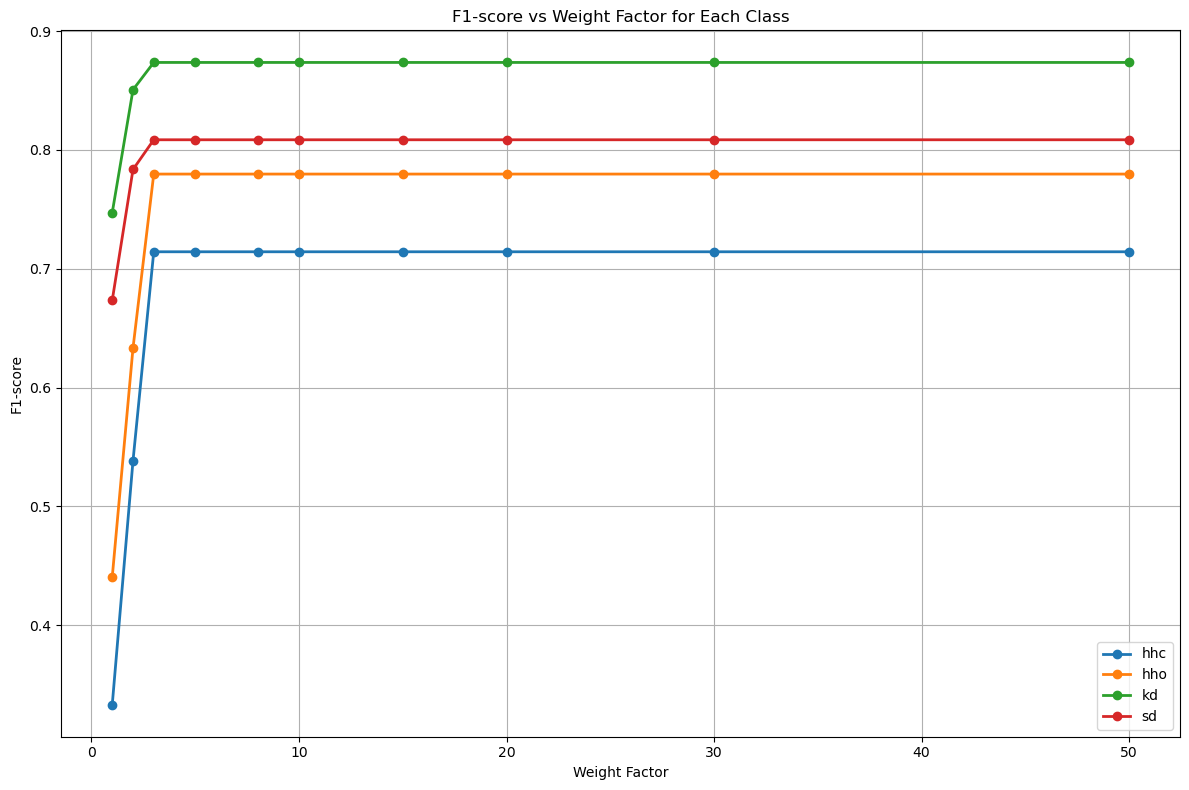


SUMMARY ACROSS ALL PARTICIPANTS
P24: Best weight factor = 3, Accuracy = 77.34%
P17: Best weight factor = 3, Accuracy = 71.77%
P10: Best weight factor = 3, Accuracy = 80.41%


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

def load_features_and_labels(features_path, labels_path, segment_info_path):
    """
    Load features and labels from specified paths.
    """
    X = np.load(features_path)
    y = np.load(labels_path)
    segment_info = pd.read_csv(segment_info_path)
    
    assert len(X) == len(y) == len(segment_info)
    return X, y, segment_info

def create_weighted_knn(X_train, y_train, X_user, y_user, weight_factor=5.0, **knn_params):
    """
    Create a KNN model where user examples have extra weight by repeating them.
    """
    # Repeat user examples to give them more weight
    n_repeats = int(weight_factor)
    X_user_repeated = np.repeat(X_user, n_repeats, axis=0)
    y_user_repeated = np.repeat(y_user, n_repeats)
    
    # Combine with training data
    X_combined = np.vstack([X_train, X_user_repeated])
    y_combined = np.concatenate([y_train, y_user_repeated])
    
    # Create and train KNN
    knn = KNeighborsClassifier(**knn_params)
    knn.fit(X_combined, y_combined)
    
    return knn

def tune_weight_factor(X, y, segment_info, held_out_participant, examples_per_class=5, 
                     weight_factors=[1, 2, 3, 5, 8, 10, 15, 20, 30, 50]):
    """
    Tune the weight factor for the weighted KNN model.
    
    Args:
        X, y: Features and labels
        segment_info: DataFrame with participant info
        held_out_participant: ID of participant to adapt to
        examples_per_class: Number of examples per class to use for adaptation
        weight_factors: List of weight factors to test
    """
    
    # Exclude held out participant from training data
    train_mask = segment_info['participant_id'] != held_out_participant
    X_train = X[train_mask]
    y_train = y[train_mask]
    segment_info_train = segment_info[train_mask]
    
    # Get held out participant's data
    test_mask = segment_info['participant_id'] == held_out_participant
    X_held_out = X[test_mask]
    y_held_out = y[test_mask]
    
    held_out_df = pd.DataFrame({
        'index': np.where(test_mask)[0],
        'label': y_held_out
    })
    
    # Get adaptation indices (5 examples per class)
    adapt_indices = []
    test_indices = []
    
    for label in np.unique(y_held_out):
        label_indices = held_out_df[held_out_df['label'] == label]['index'].values
        
        if len(label_indices) <= examples_per_class * 2:
            n_adapt = len(label_indices) // 2
        else:
            n_adapt = examples_per_class
            
        # Randomly select examples_per_class samples for adaptation
        np.random.seed(42)
        selected_indices = np.random.choice(label_indices, n_adapt, replace=False)
        
        adapt_indices.extend(selected_indices)
        # The rest are for testing
        test_indices.extend([idx for idx in label_indices if idx not in selected_indices])
    
    # Get adaptation and test data
    X_adapt = X[adapt_indices]
    y_adapt = y[adapt_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    print("\nHeld out participant's data statistics:")
    print(f"Adaptation set size: {len(X_adapt)} (5 examples per class)")
    print(f"Test set size: {len(X_test)}")
    
    print("\nLabel distribution in adaptation set:")
    print(pd.Series(y_adapt).value_counts())
    
    print("\nLabel distribution in test set:")
    print(pd.Series(y_test).value_counts())
    
    # Create group IDs for cross-validation
    base_ids = np.array([
        Path(p).stem.replace("_aug" + ''.join(filter(str.isdigit, Path(p).stem)), '')
        for p in segment_info_train['segment_path'].values
    ])
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_adapt_scaled = scaler.transform(X_adapt)
    X_test_scaled = scaler.transform(X_test)
    
    # Encode labels
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_adapt_enc = le.transform(y_adapt)
    y_test_enc = le.transform(y_test)
    
    # Define parameter grid
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
    
    # Initialize KNN and GroupKFold
    knn = KNeighborsClassifier()
    gkf = GroupKFold(n_splits=5)
    
    # Perform grid search with GroupKFold
    grid_search = GridSearchCV(
        knn,
        param_grid,
        cv=gkf.split(X_train_scaled, y_train_enc, groups=base_ids),
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Fit base model
    print("\nTraining base model (excluding held out participant)...")
    grid_search.fit(X_train_scaled, y_train_enc)
    best_params = grid_search.best_params_
    
    print("\nBest parameters:", best_params)
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
    
    print("\nTesting different weight factors...")
    weight_results = []
    
    for weight in weight_factors:
        weighted_model = create_weighted_knn(X_train_scaled, y_train_enc, X_adapt_scaled, y_adapt_enc, 
                                           weight_factor=weight, **best_params)
        weighted_preds = le.inverse_transform(weighted_model.predict(X_test_scaled))
        weighted_acc = accuracy_score(y_test, weighted_preds)
        
        # Get per-class metrics
        report = classification_report(y_test, weighted_preds, output_dict=True)
        
        weight_results.append({
            'weight_factor': weight,
            'accuracy': weighted_acc,
            'report': report
        })
        
        print(f"Weight factor {weight}: {weighted_acc:.2%}")
    
    # Find best weight factor
    best_weight = max(weight_results, key=lambda x: x['accuracy'])
    
    print(f"\nBest weight factor: {best_weight['weight_factor']} with accuracy: {best_weight['accuracy']:.2%}")
    
    print("\nDetailed classification report for best weight factor:")
    print(classification_report(y_test, le.inverse_transform(
        create_weighted_knn(X_train_scaled, y_train_enc, X_adapt_scaled, y_adapt_enc, 
                          weight_factor=best_weight['weight_factor'], **best_params)
        .predict(X_test_scaled))))
    
    plt.figure(figsize=(10, 6))
    accuracies = [result['accuracy'] for result in weight_results]
    plt.plot(weight_factors, accuracies, 'o-', linewidth=2)
    plt.axhline(y=accuracy_score(y_test, le.inverse_transform(grid_search.best_estimator_.predict(X_test_scaled))), 
               color='r', linestyle='--', label='Base Model')
    plt.xlabel('Weight Factor')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Weight Factor for Participant {held_out_participant}')
    plt.grid(True)
    plt.legend()
    
    # Add labels to the points
    for i, weight in enumerate(weight_factors):
        plt.annotate(f"{accuracies[i]:.2%}", 
                   (weight, accuracies[i]), 
                   textcoords="offset points",
                   xytext=(0,10), 
                   ha='center')
    
    plt.tight_layout()
    plt.show()
    
    class_names = le.classes_
    metrics = ['precision', 'recall', 'f1-score']
    
    for metric in metrics:
        plt.figure(figsize=(12, 8))
        
        for i, class_name in enumerate(class_names):
            values = [result['report'][class_name][metric] for result in weight_results]
            plt.plot(weight_factors, values, 'o-', linewidth=2, label=class_name)
        
        plt.xlabel('Weight Factor')
        plt.ylabel(f'{metric.capitalize()}')
        plt.title(f'{metric.capitalize()} vs Weight Factor for Each Class')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    return weight_results, best_weight

# Example usage
def main():
    features_path = "../../extracted_features/features/mfcc_extracted_features.npy"
    labels_path = "../../extracted_features/labels/mfcc_extracted_labels.npy"
    segment_info_path = "../../segment_info/segment_info.csv"
    
    # Load data
    X, y, segment_info = load_features_and_labels(features_path, labels_path, segment_info_path)
    
    # Test with different participants
    test_participants = ['P24', 'P17', 'P10']
    examples_per_class = 5
    weight_factors = [1, 2, 3, 5, 8, 10, 15, 20, 30, 50]
    
    results = {}
    for participant in test_participants:
        weight_results, best_weight = tune_weight_factor(
            X, y, segment_info, participant, examples_per_class, weight_factors
        )
        results[participant] = {'weight_results': weight_results, 'best_weight': best_weight}
    
    # Summarize results across participants
    print("\n==================================================")
    print("SUMMARY ACROSS ALL PARTICIPANTS")
    print("==================================================")
    
    for participant, result in results.items():
        print(f"{participant}: Best weight factor = {result['best_weight']['weight_factor']}, " 
             f"Accuracy = {result['best_weight']['accuracy']:.2%}")

if __name__ == "__main__":
    main()


Comparing KNN approaches for participant P24

Held out participant's data statistics:
Adaptation set size: 20 (5 examples per class)
Test set size: 128

Label distribution in adaptation set:
hhc    5
hho    5
kd     5
sd     5
Name: count, dtype: int64

Label distribution in test set:
hhc    47
hho    32
kd     28
sd     21
Name: count, dtype: int64

Training base model (excluding held out participant)...

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.870

Training basic weighted model with weight=3...

Training feature-weighted model...

Feature weights learned from user examples:
Top 5 features: [11 10  2  0  5] with weights [0.0955758  0.09795256 0.10860765 0.10884742 0.11425648]
Bottom 5 features: [7 6 1 9 4] with weights [0.0449024  0.05833054 0.06450868 0.06475915 0.07744786]

RESULTS SUMMARY
1. Base Model: 39.06%
2. Basic Weighted Model (weight=3): 78.12%
3. Feature-Weighted Model: 80.47%

1. Base Model:
       

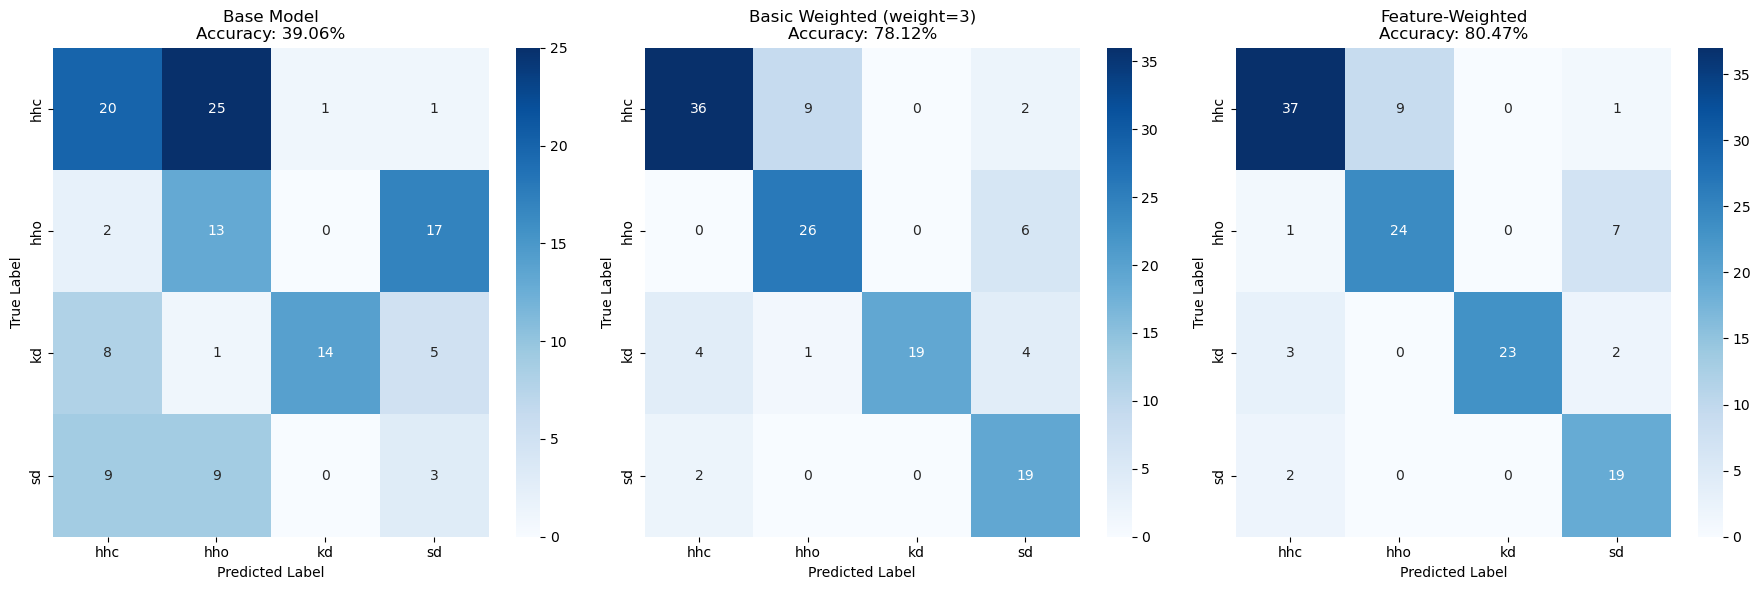

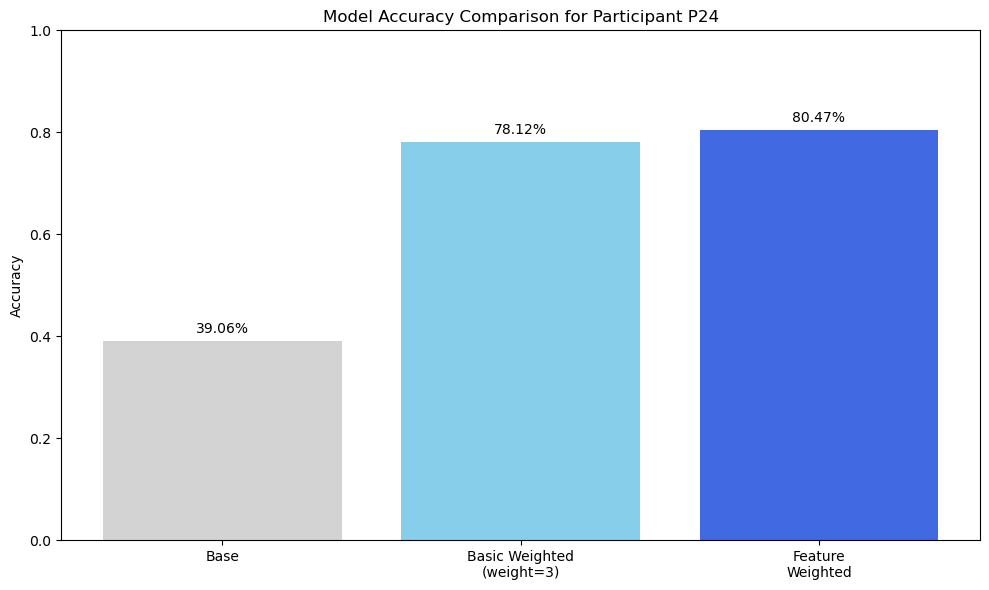

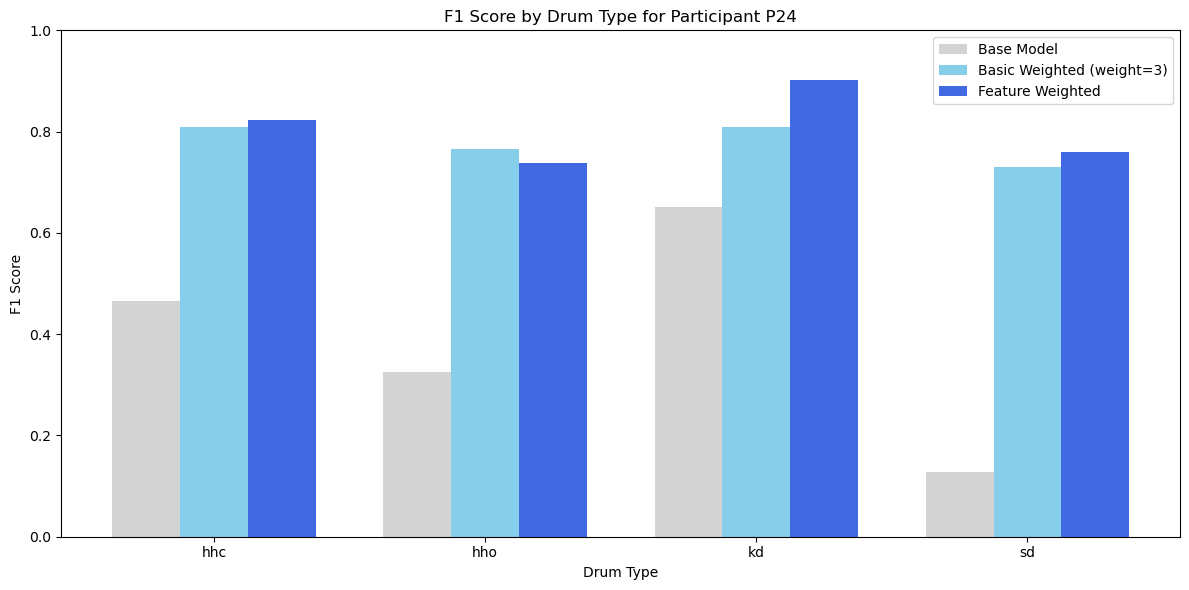

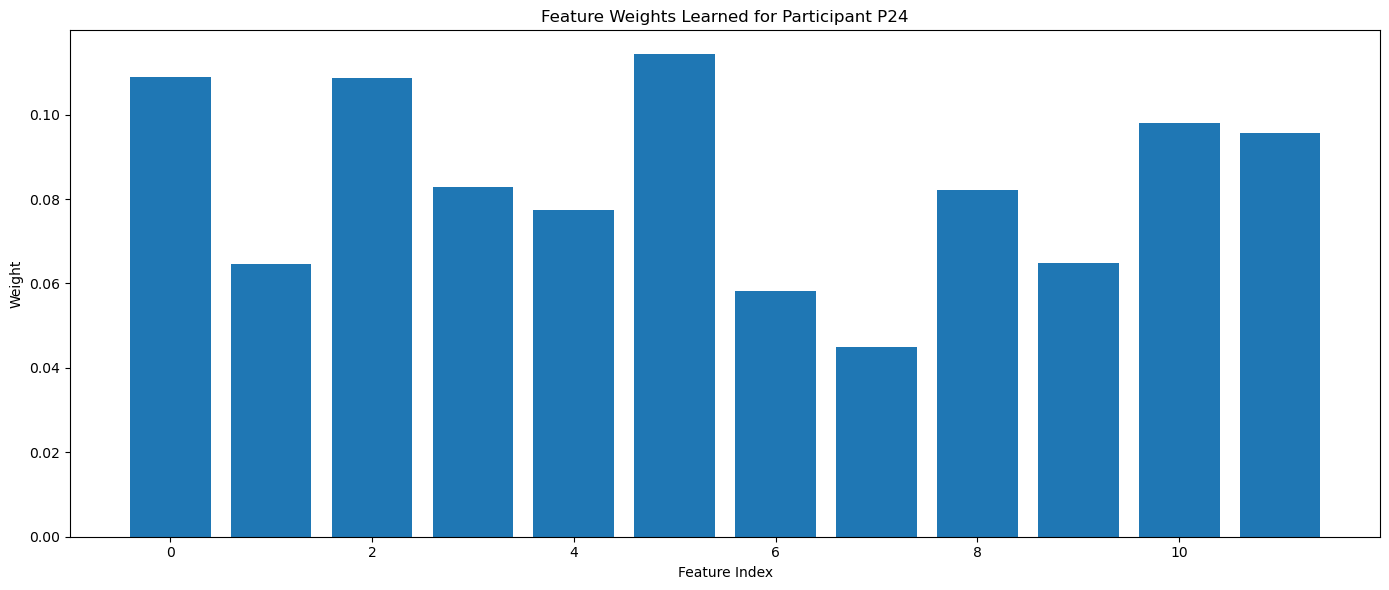


Comparing KNN approaches for participant P17

Held out participant's data statistics:
Adaptation set size: 20 (5 examples per class)
Test set size: 124

Label distribution in adaptation set:
hhc    5
hho    5
kd     5
sd     5
Name: count, dtype: int64

Label distribution in test set:
kd     43
hho    41
hhc    20
sd     20
Name: count, dtype: int64

Training base model (excluding held out participant)...

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.875

Training basic weighted model with weight=3...

Training feature-weighted model...

Feature weights learned from user examples:
Top 5 features: [10  0  3  5  9] with weights [0.08163108 0.08726698 0.1462186  0.16931599 0.18162424]
Bottom 5 features: [4 8 7 6 1] with weights [0.03191589 0.03627835 0.03698689 0.04764324 0.04913749]

RESULTS SUMMARY
1. Base Model: 44.35%
2. Basic Weighted Model (weight=3): 69.35%
3. Feature-Weighted Model: 70.97%

1. Base Model:
       

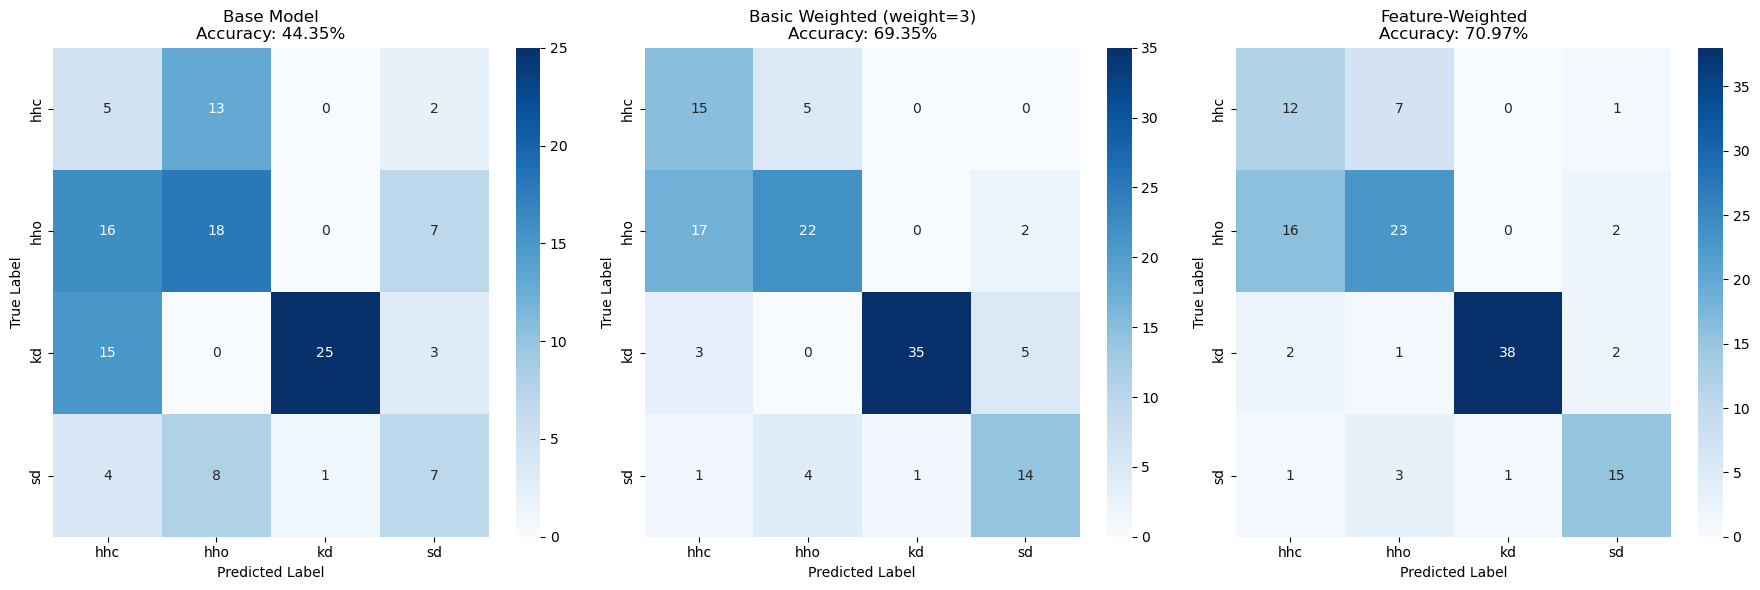

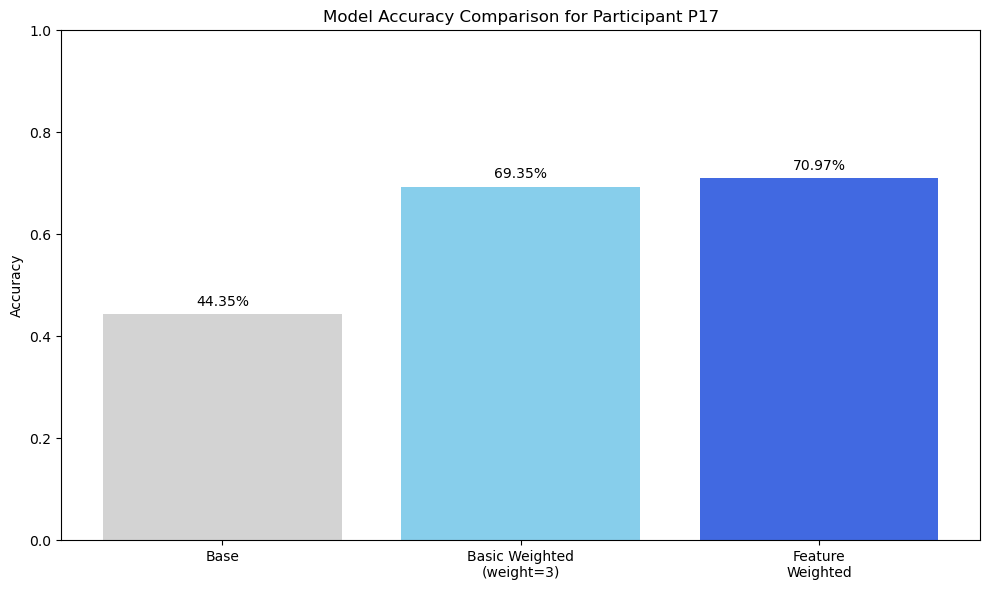

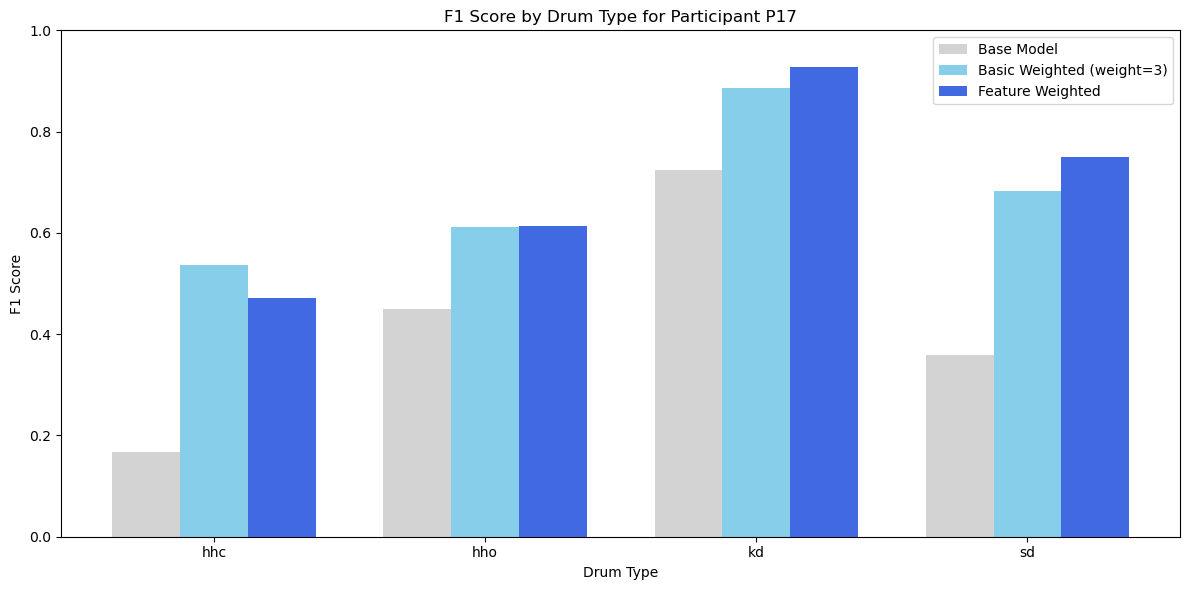

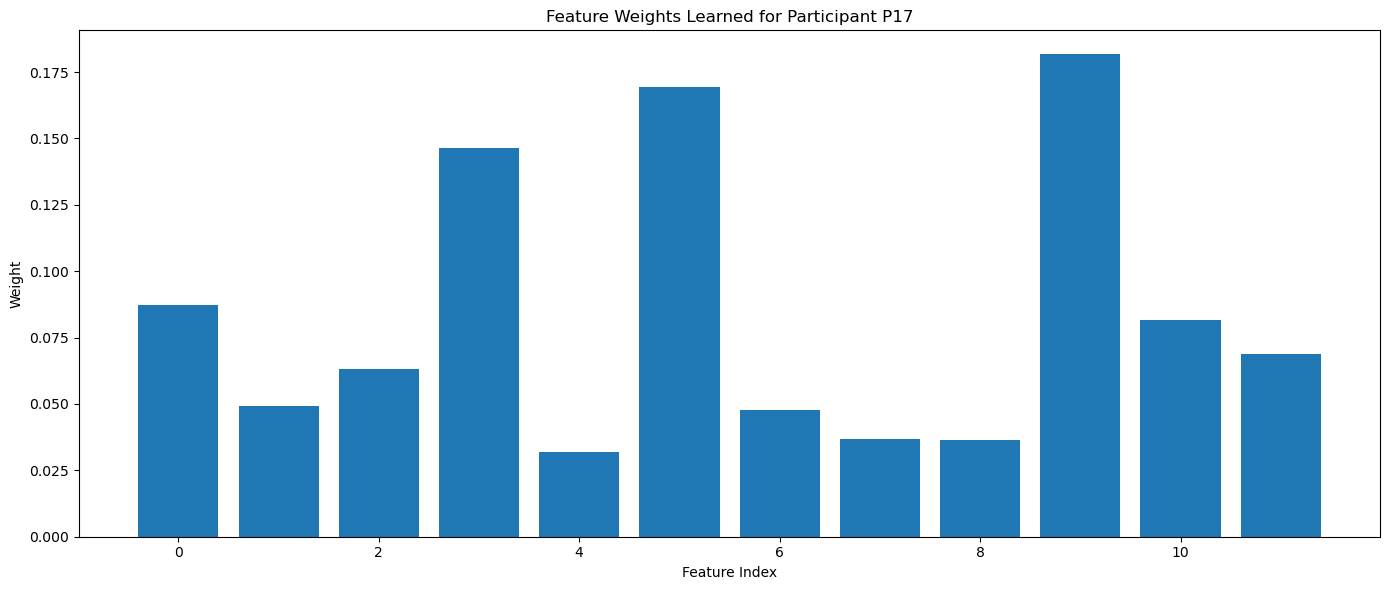


Comparing KNN approaches for participant P10

Held out participant's data statistics:
Adaptation set size: 20 (5 examples per class)
Test set size: 148

Label distribution in adaptation set:
hhc    5
hho    5
kd     5
sd     5
Name: count, dtype: int64

Label distribution in test set:
kd     47
sd     40
hhc    32
hho    29
Name: count, dtype: int64

Training base model (excluding held out participant)...

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.872

Training basic weighted model with weight=3...

Training feature-weighted model...

Feature weights learned from user examples:
Top 5 features: [3 6 0 4 2] with weights [0.09011823 0.11164117 0.12048757 0.14847976 0.17069255]
Bottom 5 features: [ 5 10 11  1  8] with weights [0.03071206 0.03670379 0.04007912 0.04801846 0.06107229]

RESULTS SUMMARY
1. Base Model: 34.46%
2. Basic Weighted Model (weight=3): 80.41%
3. Feature-Weighted Model: 81.76%

1. Base Model:
       

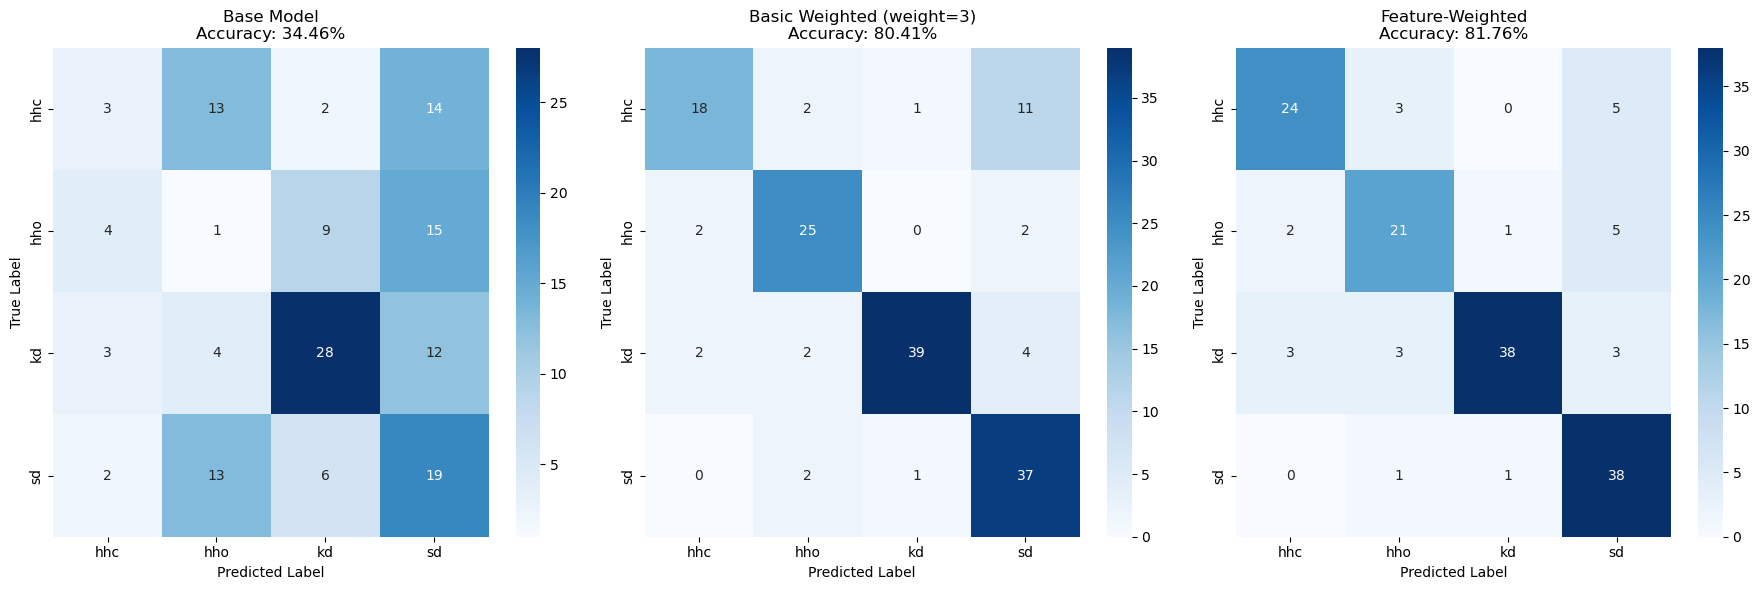

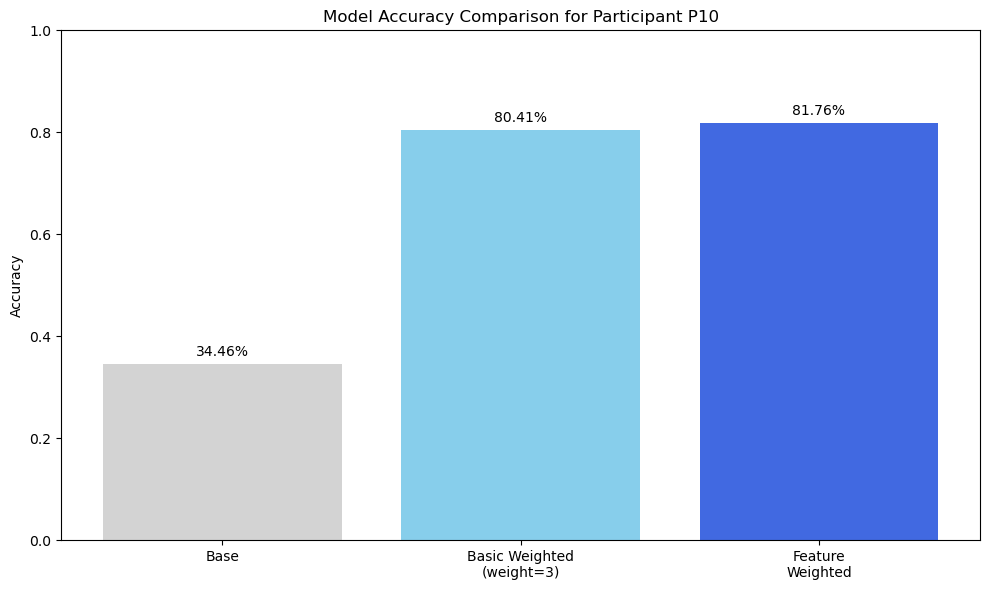

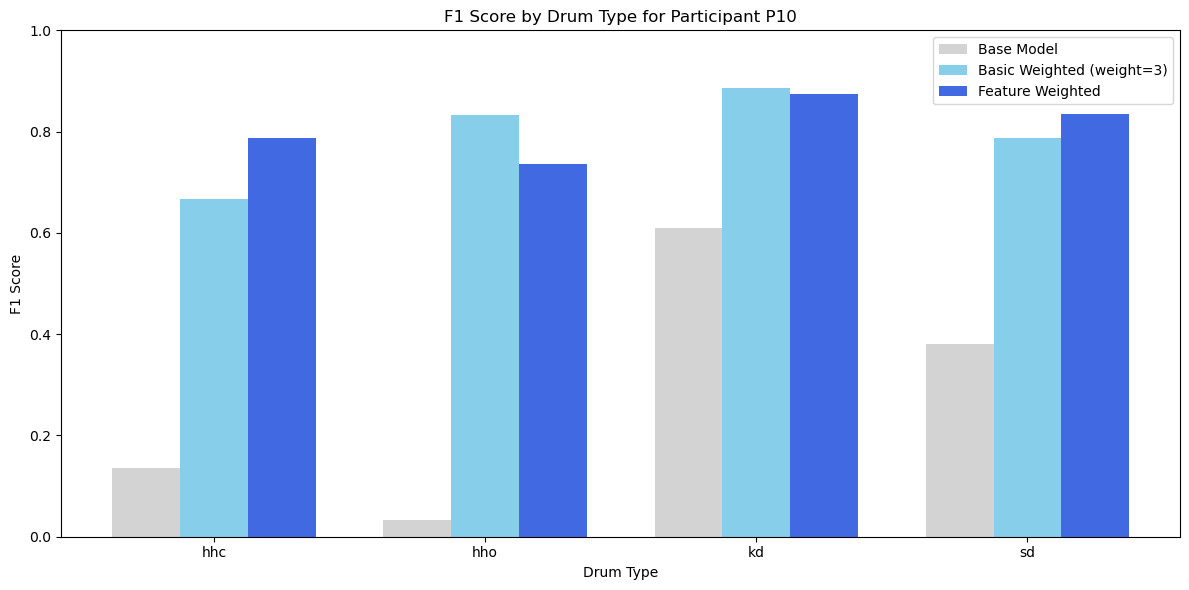

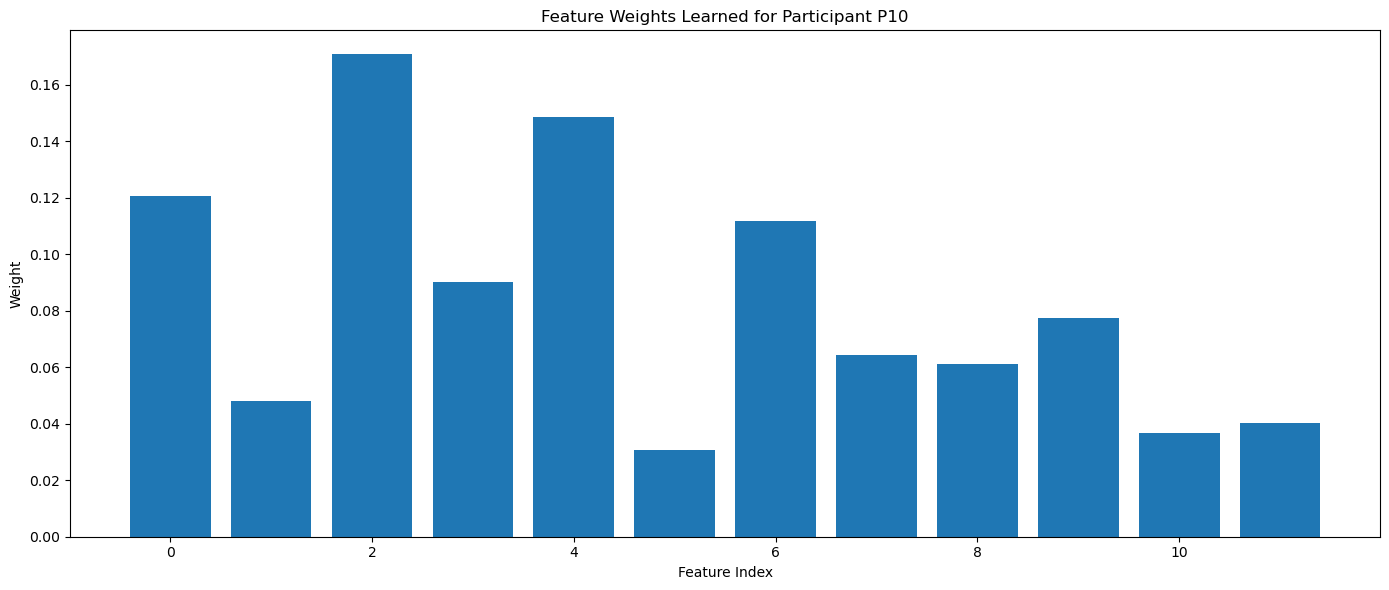


FINAL SUMMARY ACROSS ALL PARTICIPANTS

P24:
  Base accuracy: 39.06%
  Basic weighted accuracy: 78.12%
  Feature weighted accuracy: 80.47%
  Improvements:
    vs. Base: +41.4%
    vs. Basic Weighted: +2.3%
  Top 5 features: [11 10  2  0  5]

P17:
  Base accuracy: 44.35%
  Basic weighted accuracy: 69.35%
  Feature weighted accuracy: 70.97%
  Improvements:
    vs. Base: +26.6%
    vs. Basic Weighted: +1.6%
  Top 5 features: [10  0  3  5  9]

P10:
  Base accuracy: 34.46%
  Basic weighted accuracy: 80.41%
  Feature weighted accuracy: 81.76%
  Improvements:
    vs. Base: +47.3%
    vs. Basic Weighted: +1.4%
  Top 5 features: [3 6 0 4 2]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

def load_features_and_labels(features_path, labels_path, segment_info_path):
    """
    Load features and labels from specified paths.
    """
    X = np.load(features_path)
    y = np.load(labels_path)
    segment_info = pd.read_csv(segment_info_path)
    
    assert len(X) == len(y) == len(segment_info)
    return X, y, segment_info

def create_basic_weighted_knn(X_train, y_train, X_user, y_user, weight_factor=3.0, **knn_params):
    """
    Create a KNN model where user examples have extra weight by repeating them.
    """
    # Repeat user examples to give them more weight
    n_repeats = int(weight_factor)
    X_user_repeated = np.repeat(X_user, n_repeats, axis=0)
    y_user_repeated = np.repeat(y_user, n_repeats)
    
    # Combine with training data
    X_combined = np.vstack([X_train, X_user_repeated])
    y_combined = np.concatenate([y_train, y_user_repeated])
    
    # Create and train KNN
    knn = KNeighborsClassifier(**knn_params)
    knn.fit(X_combined, y_combined)
    
    return knn

def create_feature_weighted_knn(X_train, y_train, X_user, y_user, weight_factor=3.0, 
                              feature_weight_method='ridge', C=1.0, **knn_params):
    """
    Create a KNN model with learned feature weights.
    
    Args:
        X_train, y_train: Base training data
        X_user, y_user: User examples
        weight_factor: How many times to repeat user examples
        feature_weight_method: 'ridge', 'lasso', or 'logistic'
        C: Regularization strength
        knn_params: Parameters for KNeighborsClassifier
    """
    # Learn feature weights from user examples
    if feature_weight_method == 'ridge':
        # Ridge regression for feature weights
        model = RidgeClassifier(alpha=1.0/C)
    elif feature_weight_method == 'lasso':
        # Lasso regression for feature weights (use LogisticRegression with L1)
        model = LogisticRegression(penalty='l1', C=C, solver='liblinear')
    else:
        # Default to logistic regression with L1 regularization
        model = LogisticRegression(penalty='l1', C=C, solver='liblinear')
    
    model.fit(X_user, y_user)
    
    # Get feature weights
    if hasattr(model, 'coef_'):
        if len(model.coef_.shape) == 2:
            # For multiclass models, take the average of absolute values across all classes
            feature_weights = np.mean(np.abs(model.coef_), axis=0)
        else:
            feature_weights = np.abs(model.coef_)
    else:
        feature_weights = np.ones(X_user.shape[1])
    
    # Normalize weights to sum to 1
    feature_weights = feature_weights / np.sum(feature_weights)
    
    top_indices = np.argsort(feature_weights)[-5:]
    bottom_indices = np.argsort(feature_weights)[:5]
    
    print("\nFeature weights learned from user examples:")
    print(f"Top 5 features: {top_indices} with weights {feature_weights[top_indices]}")
    print(f"Bottom 5 features: {bottom_indices} with weights {feature_weights[bottom_indices]}")
    
    # Repeat user examples to give them more weight
    n_repeats = int(weight_factor)
    X_user_repeated = np.repeat(X_user, n_repeats, axis=0)
    y_user_repeated = np.repeat(y_user, n_repeats)
    
    X_combined = np.vstack([X_train, X_user_repeated])
    y_combined = np.concatenate([y_train, y_user_repeated])
    
    # Define a custom distance function with feature weights
    def weighted_euclidean(x, y):
        return np.sqrt(np.sum(feature_weights * ((x - y) ** 2)))
    
    # Create KNN with custom metric using learned weights
    # Override any metric parameters in knn_params
    params = knn_params.copy()
    params['metric'] = 'pyfunc'
    params['metric_params'] = {'func': weighted_euclidean}
    
    knn = KNeighborsClassifier(**params)
    knn.fit(X_combined, y_combined)
    
    return knn, feature_weights

def compare_all_knn_approaches(X, y, segment_info, held_out_participant, examples_per_class=5):
    """
    Compare all KNN approaches:
    1. Base model (no participant data)
    2. Basic weighted model with weight=3
    3. Feature-weighted model
    
    Args:
        X, y: Features and labels
        segment_info: DataFrame with participant info
        held_out_participant: ID of participant to adapt to
        examples_per_class: Number of examples per class to use for adaptation
    """

    
    # Exclude held out participant from training data
    train_mask = segment_info['participant_id'] != held_out_participant
    X_train = X[train_mask]
    y_train = y[train_mask]
    segment_info_train = segment_info[train_mask]
    
    # Get held out participant's data
    test_mask = segment_info['participant_id'] == held_out_participant
    X_held_out = X[test_mask]
    y_held_out = y[test_mask]
    
    held_out_df = pd.DataFrame({
        'index': np.where(test_mask)[0],
        'label': y_held_out
    })
    
    # Get adaptation indices (5 examples per class)
    adapt_indices = []
    test_indices = []
    
    for label in np.unique(y_held_out):
        label_indices = held_out_df[held_out_df['label'] == label]['index'].values
        
        if len(label_indices) <= examples_per_class * 2:
            n_adapt = len(label_indices) // 2
        else:
            n_adapt = examples_per_class
            
        # Randomly select examples_per_class samples for adaptation
        np.random.seed(42)
        selected_indices = np.random.choice(label_indices, n_adapt, replace=False)
        
        adapt_indices.extend(selected_indices)
        # The rest are for testing
        test_indices.extend([idx for idx in label_indices if idx not in selected_indices])
    
    # Get adaptation and test data
    X_adapt = X[adapt_indices]
    y_adapt = y[adapt_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    print("\nHeld out participant's data statistics:")
    print(f"Adaptation set size: {len(X_adapt)} (5 examples per class)")
    print(f"Test set size: {len(X_test)}")
    
    print("\nLabel distribution in adaptation set:")
    print(pd.Series(y_adapt).value_counts())
    
    print("\nLabel distribution in test set:")
    print(pd.Series(y_test).value_counts())
    
    # Create group IDs for cross-validation
    base_ids = np.array([
        Path(p).stem.replace("_aug" + ''.join(filter(str.isdigit, Path(p).stem)), '')
        for p in segment_info_train['segment_path'].values
    ])
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_adapt_scaled = scaler.transform(X_adapt)
    X_test_scaled = scaler.transform(X_test)
    
    # Encode labels
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_adapt_enc = le.transform(y_adapt)
    y_test_enc = le.transform(y_test)
    
    # Define parameter grid
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
    
    # Initialize KNN and GroupKFold
    knn = KNeighborsClassifier()
    gkf = GroupKFold(n_splits=5)
    
    # Perform grid search with GroupKFold
    grid_search = GridSearchCV(
        knn,
        param_grid,
        cv=gkf.split(X_train_scaled, y_train_enc, groups=base_ids),
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Fit base model
    print("\nTraining base model (excluding held out participant)...")
    grid_search.fit(X_train_scaled, y_train_enc)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print("\nBest parameters:", best_params)
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
    
    base_preds = le.inverse_transform(best_model.predict(X_test_scaled))
    base_acc = accuracy_score(y_test, base_preds)
    
    # Create basic weighted model with weight=3
    print("\nTraining basic weighted model with weight=3...")
    
    # Extract relevant parameters for KNN
    knn_params = {}
    for param in ['n_neighbors', 'weights']:
        if param in best_params:
            knn_params[param] = best_params[param]
    
    basic_weighted_model = create_basic_weighted_knn(
        X_train_scaled, y_train_enc, X_adapt_scaled, y_adapt_enc, 
        weight_factor=3, **knn_params
    )
    basic_weighted_preds = le.inverse_transform(basic_weighted_model.predict(X_test_scaled))
    basic_weighted_acc = accuracy_score(y_test, basic_weighted_preds)
    
    print("\nTraining feature-weighted model...")
    feature_weighted_model, feature_weights = create_feature_weighted_knn(
        X_train_scaled, y_train_enc, X_adapt_scaled, y_adapt_enc,
        weight_factor=3, feature_weight_method='ridge', C=1.0, **knn_params
    )
    feature_weighted_preds = le.inverse_transform(feature_weighted_model.predict(X_test_scaled))
    feature_weighted_acc = accuracy_score(y_test, feature_weighted_preds)
    
    print("\n==================================================")
    print("RESULTS SUMMARY")
    print("==================================================")
    print(f"1. Base Model: {base_acc:.2%}")
    print(f"2. Basic Weighted Model (weight=3): {basic_weighted_acc:.2%}")
    print(f"3. Feature-Weighted Model: {feature_weighted_acc:.2%}")
    
    # Print detailed classification reports
    print("\n1. Base Model:")
    print(classification_report(y_test, base_preds))
    
    print("\n2. Basic Weighted Model (weight=3):")
    print(classification_report(y_test, basic_weighted_preds))
    
    print("\n3. Feature-Weighted Model:")
    print(classification_report(y_test, feature_weighted_preds))
    
    # Calculate per-class improvements
    base_report = classification_report(y_test, base_preds, output_dict=True)
    basic_weighted_report = classification_report(y_test, basic_weighted_preds, output_dict=True)
    feature_weighted_report = classification_report(y_test, feature_weighted_preds, output_dict=True)
    
    print("\nPer-class F1-score improvements from feature-weighted model:")
    for class_name in le.classes_:
        base_f1 = base_report[class_name]['f1-score']
        basic_f1 = basic_weighted_report[class_name]['f1-score']
        feature_f1 = feature_weighted_report[class_name]['f1-score']
        base_to_feature = (feature_f1 - base_f1) * 100
        basic_to_feature = (feature_f1 - basic_f1) * 100
        print(f"  {class_name}: Base={base_f1:.2f}, Basic={basic_f1:.2f}, Feature={feature_f1:.2f} " 
              f"(vs Base: {base_to_feature:+.1f}%, vs Basic: {basic_to_feature:+.1f}%)")
    
    # Visualize confusion matrices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # Base model confusion matrix
    cm_base = confusion_matrix(y_test, base_preds, labels=le.classes_)
    sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_, ax=ax1)
    ax1.set_title(f'Base Model\nAccuracy: {base_acc:.2%}')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    
    # Basic weighted model confusion matrix
    cm_basic = confusion_matrix(y_test, basic_weighted_preds, labels=le.classes_)
    sns.heatmap(cm_basic, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_, ax=ax2)
    ax2.set_title(f'Basic Weighted (weight=3)\nAccuracy: {basic_weighted_acc:.2%}')
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')
    
    # Feature-weighted model confusion matrix
    cm_feature = confusion_matrix(y_test, feature_weighted_preds, labels=le.classes_)
    sns.heatmap(cm_feature, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_, ax=ax3)
    ax3.set_title(f'Feature-Weighted\nAccuracy: {feature_weighted_acc:.2%}')
    ax3.set_ylabel('True Label')
    ax3.set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.savefig(f'confusion_matrices_{held_out_participant}.png')
    plt.show()
    
    # Visualize results
    models = ['Base', 'Basic Weighted\n(weight=3)', 'Feature\nWeighted']
    accuracies = [base_acc, basic_weighted_acc, feature_weighted_acc]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color=['lightgray', 'skyblue', 'royalblue'])
    plt.ylim(0, 1.0)
    plt.ylabel('Accuracy')
    plt.title(f'Model Accuracy Comparison for Participant {held_out_participant}')
    
    # Add accuracy values on top of bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.2%}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(f'accuracy_comparison_{held_out_participant}.png')
    plt.show()
    
    # Also show per-class F1 scores
    class_names = le.classes_
    base_f1 = [base_report[cls]['f1-score'] for cls in class_names]
    basic_f1 = [basic_weighted_report[cls]['f1-score'] for cls in class_names]
    feature_f1 = [feature_weighted_report[cls]['f1-score'] for cls in class_names]
    
    x = np.arange(len(class_names))
    width = 0.25
    
    plt.figure(figsize=(12, 6))
    plt.bar(x - width, base_f1, width, label='Base Model', color='lightgray')
    plt.bar(x, basic_f1, width, label='Basic Weighted (weight=3)', color='skyblue')
    plt.bar(x + width, feature_f1, width, label='Feature Weighted', color='royalblue')
    
    plt.xlabel('Drum Type')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Score by Drum Type for Participant {held_out_participant}')
    plt.xticks(x, class_names)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'f1_scores_{held_out_participant}.png')
    plt.show()
    
    # Visualize feature weights
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(feature_weights)), feature_weights)
    plt.xlabel('Feature Index')
    plt.ylabel('Weight')
    plt.title(f'Feature Weights Learned for Participant {held_out_participant}')
    plt.tight_layout()
    plt.savefig(f'feature_weights_{held_out_participant}.png')
    plt.show()
    
    return {
        'base_model': best_model,
        'basic_weighted_model': basic_weighted_model,
        'feature_weighted_model': feature_weighted_model,
        'feature_weights': feature_weights,
        'base_acc': base_acc,
        'basic_weighted_acc': basic_weighted_acc,
        'feature_weighted_acc': feature_weighted_acc
    }

# Example usage
def main():
    features_path = "../../extracted_features/features/mfcc_extracted_features.npy"
    labels_path = "../../extracted_features/labels/mfcc_extracted_labels.npy"
    segment_info_path = "../../segment_info/segment_info.csv"
    
    # Load data
    X, y, segment_info = load_features_and_labels(features_path, labels_path, segment_info_path)
    
    # Test with different participants
    test_participants = ['P24', 'P17', 'P10']
    examples_per_class = 5
    
    all_results = {}
    for participant in test_participants:
        all_results[participant] = compare_all_knn_approaches(
            X, y, segment_info, participant, examples_per_class
        )
    
    # Summarize results across participants
    print("\n==================================================")
    print("FINAL SUMMARY ACROSS ALL PARTICIPANTS")
    print("==================================================")
    
    for participant, results in all_results.items():
        print(f"\n{participant}:")
        print(f"  Base accuracy: {results['base_acc']:.2%}")
        print(f"  Basic weighted accuracy: {results['basic_weighted_acc']:.2%}")
        print(f"  Feature weighted accuracy: {results['feature_weighted_acc']:.2%}")
        
        base_improvement = (results['feature_weighted_acc'] - results['base_acc']) * 100
        basic_improvement = (results['feature_weighted_acc'] - results['basic_weighted_acc']) * 100
        print(f"  Improvements:")
        print(f"    vs. Base: {base_improvement:+.1f}%")
        print(f"    vs. Basic Weighted: {basic_improvement:+.1f}%")
        
        # Print top features
        feature_weights = results['feature_weights']
        top_indices = np.argsort(feature_weights)[-5:]
        print(f"  Top 5 features: {top_indices}")

if __name__ == "__main__":
    main()